<a href="https://colab.research.google.com/github/AmyHumke12/SolarProject/blob/main/IPTV_SolarEdgeData_Step1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This Notebook Sets up the SolarEdge data, Weather, Sun, Electricity use, and expected production for this area datasets.

##Requirements

In [1]:
!pip install astral
!pip install pandasql
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

In [2]:
#Requirements
import pandas as pd
import pandasql as psql
import numpy as np
import requests
from datetime import datetime, timedelta
import os
from retry_requests import retry
import openmeteo_requests
import requests_cache
import pandasql as psql
import requests
import time
import matplotlib.pyplot as plt
import pytz
import time
from io import BytesIO
from astral import LocationInfo
from astral.sun import sun, elevation, azimuth



In [3]:
# Load secrets from GitHub Codespaces
SOLAREDGE_API_KEY = os.getenv("SOLAREDGE_API_KEY")
SOLAREDGE_SITE_ID = os.getenv("SOLAREDGE_SITE_ID")

# Check if secrets are loaded correctly
if not SOLAREDGE_API_KEY or not SOLAREDGE_SITE_ID:
    raise ValueError("❌ SolarEdge API credentials are missing. Make sure they are set in GitHub Codespaces Secrets!")

print("✅ SolarEdge credentials loaded successfully!")


✅ SolarEdge credentials loaded successfully!


In [36]:
# File ID from Google Sheets
file_id = "1sd0RsLIxi6WN-tPn-DykxQ51WIZofurX"
sheet_url = f"https://docs.google.com/spreadsheets/d/{file_id}/export?format=csv"

# Load Google Sheet as DataFrame
electric = pd.read_csv(sheet_url)

# Show first few rows
print(electric.head())


             TYPE      DATE START_TIME END_TIME  USAGE_(kWh)    COST  \
0  Electric usage  1/1/2023       0:00     0:29         0.72  $0.00    
1  Electric usage  1/1/2023       0:30     0:59         0.74  $0.00    
2  Electric usage  1/1/2023       1:00     1:29         0.75  $0.00    
3  Electric usage  1/1/2023       1:30     1:59         0.77  $0.00    
4  Electric usage  1/1/2023       2:00     2:29         0.69  $0.00    

   ESTIMATED_USAGE  NOTES  
0              NaN    NaN  
1              NaN    NaN  
2              NaN    NaN  
3              NaN    NaN  
4              NaN    NaN  


#Get estimated hourly production by month from GlobalSolarAtas.info

In [5]:
# Define the solar generation values for each month and hour from the heatmap
solar_data = {
    'Jan': [0, 0, 0, 0, 0, 0, 0.038, 0.494, 2.773, 4.560, 5.780, 6.316, 6.095, 5.351, 4.487, 2.965, 0.571, 0.011, 0, 0, 0, 0, 0, 0],
    'Feb': [0, 0, 0, 0, 0, 0.101, 0.391, 1.353, 3.849, 5.804, 7.220, 7.843, 7.708, 6.917, 5.962, 4.257, 1.959, 0.439, 0, 0, 0, 0, 0, 0],
    'Mar': [0, 0, 0, 0, 0, 0.437, 1.269, 2.490, 4.551, 6.457, 7.729, 8.340, 8.180, 7.412, 6.244, 4.617, 2.504, 0.752, 0, 0, 0, 0, 0, 0],
    'Apr': [0, 0, 0, 0, 0, 0.476, 1.662, 3.384, 5.321, 6.852, 8.020, 8.346, 8.194, 7.513, 6.253, 4.552, 2.527, 1.019, 0.344, 0.029, 0, 0, 0, 0],
    'May': [0, 0, 0, 0, 0, 0.399, 1.662, 3.629, 5.372, 6.873, 7.805, 8.209, 7.948, 7.400, 6.232, 4.648, 2.736, 1.019, 0.107, 0.210, 0, 0, 0, 0],
    'Jun': [0, 0, 0, 0, 0, 0.149, 1.502, 3.674, 5.494, 6.983, 8.071, 8.479, 8.393, 7.819, 6.661, 5.025, 3.063, 1.215, 0.365, 0.344, 0, 0, 0, 0],
    'Jul': [0, 0, 0, 0, 0, 0.065, 1.271, 3.590, 5.641, 7.226, 8.204, 8.664, 8.597, 7.998, 6.856, 5.304, 3.297, 1.345, 0.344, 0.344, 0, 0, 0, 0],
    'Aug': [0, 0, 0, 0, 0, 0.149, 1.065, 3.376, 5.364, 6.990, 8.090, 8.575, 8.473, 7.806, 6.709, 5.066, 2.973, 1.000, 0.107, 0.029, 0, 0, 0, 0],
    'Sep': [0, 0, 0, 0, 0, 0.149, 1.065, 3.323, 5.414, 7.160, 8.211, 8.532, 8.260, 7.526, 6.338, 4.494, 2.973, 1.000, 0.321, 0.344, 0, 0, 0, 0],
    'Oct': [0, 0, 0, 0, 0, 0.488, 2.794, 4.765, 6.248, 7.074, 7.564, 7.261, 6.879, 6.043, 4.860, 3.111, 2.297, 1.000, 0.029, 0.344, 0, 0, 0, 0],
    'Nov': [0, 0, 0, 0, 0, 0.463, 1.507, 3.738, 5.356, 6.324, 6.574, 6.298, 5.511, 4.217, 3.768, 2.219, 1.932, 0.878, 0.107, 0.138, 0, 0, 0, 0],
    'Dec': [0, 0, 0, 0, 0, 0.463, 2.614, 4.237, 5.243, 5.683, 5.427, 5.298, 4.739, 3.768, 3.168, 1.932, 1.000, 0.463, 0.344, 0.107, 0, 0, 0, 0]
}

# Create a list of hours in a day
hours = list(range(24))

# Initialize an empty list to hold the data
data = []

# Loop through each month and hour to populate the dataframe
for month, values in solar_data.items():
    for hour in hours:
        value = values[hour]
        data.append([month, hour, value])

# Create the DataFrame
df_solar = pd.DataFrame(data, columns=['Month', 'Hour', 'Solar_Generation'])

# Display the DataFrame
print(df_solar)


    Month  Hour  Solar_Generation
0     Jan     0             0.000
1     Jan     1             0.000
2     Jan     2             0.000
3     Jan     3             0.000
4     Jan     4             0.000
..    ...   ...               ...
283   Dec    19             0.107
284   Dec    20             0.000
285   Dec    21             0.000
286   Dec    22             0.000
287   Dec    23             0.000

[288 rows x 3 columns]


In [6]:
df_solar

,Month,Hour,Solar_Generation
0,Jan,0,0.000
1,Jan,1,0.000
2,Jan,2,0.000
3,Jan,3,0.000
4,Jan,4,0.000
...,...,...,...
283,Dec,19,0.107
284,Dec,20,0.000
285,Dec,21,0.000
286,Dec,22,0.000


In [7]:
# Define the filename
file_path = "solar_production_estimate.pkl"

# Save the updated DataFrame
df_solar.to_pickle(file_path)
print("✅ Data saved locally.")

# Push the file to GitHub
os.system("git add solar_production_estimate.pkl")
os.system('git commit -m "Updated solar production estimate"')
os.system("git push origin main")

print("🚀 Data pushed to GitHub!")


✅ Data saved locally.
[main 1e4981f] Updated solar production estimate
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 solar_production_estimate.pkl
🚀 Data pushed to GitHub!


To https://github.com/AmyHumke12/SolarProject
   814c514..1e4981f  main -> main


#Get Consumption and Production Data from SolarEdge
- Only one month of data is allowed at a time
- Put it in a loop to get the data and keep appending
- If it runs with no data it will still run, if there is data it will check the last date in the file and then run to current date

In [9]:
# Load API credentials from environment variables
SOLAREDGE_API_KEY = os.getenv('SOLAREDGE_API_KEY')
SOLAREDGE_SITE_ID = os.getenv('SOLAREDGE_SITE_ID')

# API URL for fetching energy details
API_URL = f"https://monitoringapi.solaredge.com/site/{SOLAREDGE_SITE_ID}/energyDetails"

# Define the filename for storing raw data
file_path = "iptv_solaredge_data_raw.pkl"

# Try to load existing data if available
if os.path.exists(file_path):
    solaredge_df = pd.read_pickle(file_path)
    print("✅ Loaded existing data.")
else:
    solaredge_df = pd.DataFrame()  # Initialize an empty DataFrame if no file exists
    print("⚠️ No existing data found, starting fresh.")

# Function to fetch data from SolarEdge API
def fetch_solaredge_details(start_time, end_time):
    params = {
        'meters': 'Production,Consumption,FeedIn,Purchased',
        'startTime': start_time,
        'endTime': end_time,
        'api_key': SOLAREDGE_API_KEY,
        'timeUnit': 'HOUR'
    }

    max_retries = 3
    for attempt in range(max_retries):
        response = requests.get(API_URL, params=params)
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 429:
            print(f"Rate limit hit. Retrying... (Attempt {attempt + 1}/{max_retries})")
            time.sleep(60)  # Wait for 60 seconds before retrying
        else:
            response.raise_for_status()
    raise Exception(f"❌ Failed to fetch data after {max_retries} attempts.")

# Function to normalize data into a DataFrame
def normalize_data(data):
    meters = data['energyDetails']['meters']
    df_list = []
    for meter in meters:
        df = pd.json_normalize(meter, 'values')
        df['meter_type'] = meter['type']
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

# Determine the start date for fetching new data
if not solaredge_df.empty:
    solaredge_df['date'] = pd.to_datetime(solaredge_df['date'], errors='coerce')
    last_date = solaredge_df['date'].max()
    start_time_dt = last_date + timedelta(days=1)
else:
    start_time_dt = datetime(2024, 1, 1)  # Start from January 1, 2024 if no data exists

# End date is yesterday at 11:59 PM
end_of_yesterday = (datetime.now() - timedelta(days=1)).replace(hour=23, minute=59, second=59, microsecond=0)

# Fetch data only if new data is needed
if start_time_dt > end_of_yesterday:
    print("✅ Data is already up-to-date.")
else:
    # Loop through each day/month to fetch data
    while start_time_dt <= end_of_yesterday:
        if start_time_dt.month == datetime.now().month:
            end_time_dt = start_time_dt.replace(hour=23, minute=59, second=59)
            time.sleep(1)  # Avoid hitting rate limits
        else:
            next_month = (start_time_dt.replace(day=1) + timedelta(days=32)).replace(day=1)
            end_time_dt = min(next_month - timedelta(seconds=1), end_of_yesterday)

        start_time = start_time_dt.strftime('%Y-%m-%d %H:%M:%S')
        end_time = end_time_dt.strftime('%Y-%m-%d %H:%M:%S')

        print(f"📡 Fetching data from {start_time} to {end_time}")
        try:
            data_period = fetch_solaredge_details(start_time, end_time)
            if data_period:
                df = normalize_data(data_period)
                solaredge_df = pd.concat([solaredge_df, df], ignore_index=True)
                solaredge_df.drop_duplicates(subset=['date', 'meter_type'], inplace=True)
            else:
                print("⚠️ No data returned for this period.")
        except requests.exceptions.HTTPError as http_err:
            print(f"❌ HTTP error occurred: {http_err}")
            break

        # Move to the next day or month
        start_time_dt = start_time_dt + timedelta(days=1) if start_time_dt.month == datetime.now().month else next_month

# Save the updated DataFrame locally
solaredge_df.to_pickle(file_path)
print(f"✅ Data saved to {file_path}")

# Push the file to GitHub
os.system("git add iptv_solaredge_data_raw.pkl")
os.system('git commit -m "Updated SolarEdge raw data"')
os.system("git push origin main")

print("🚀 Data pushed to GitHub!")


✅ Loaded existing data.
✅ Data is already up-to-date.
✅ Data saved to iptv_solaredge_data_raw.pkl
[main 8f89544] Updated SolarEdge raw data
 1 file changed, 0 insertions(+), 0 deletions(-)
🚀 Data pushed to GitHub!


To https://github.com/AmyHumke12/SolarProject
   7baa9d1..8f89544  main -> main


In [ ]:
#Code to erase the solaredge data and start fresh if needed
# Define the filename (same as used in your main script)
#file_path = "iptv_solaredge_data_raw.pkl"

# Create an empty DataFrame
#empty_df = pd.DataFrame()

# Save the empty DataFrame, overwriting existing data
#empty_df.to_pickle(file_path)

#print(f"The file '{file_path}' has been erased and replaced with an empty DataFrame.")

# Push the reset file to GitHub
#os.system(f"git add {file_path}")
#os.system('git commit -m "Reset SolarEdge raw data to empty DataFrame"')
#os.system("git push origin main")

#print("Reset file pushed to GitHub!")


The solaredge_data.pkl file has been erased and replaced with an empty DataFrame.


In [11]:
import os
import pandas as pd
from datetime import datetime, timedelta

# Define the filename for saving the cleaned data
file_path = "iptv_solaredge_data_cleaned.pkl"

# Ensure the 'date' column is in datetime format
solaredge_df['date'] = pd.to_datetime(solaredge_df['date'])

# Get the current UTC time
utc_now = datetime.utcnow()

# Adjust for the local timezone (assuming your timezone is UTC-5, adjust accordingly)
local_now = utc_now - timedelta(hours=5)

# Extract just the local date
today_date = pd.to_datetime(local_now.date())

# Filter out rows with today's date (to remove incomplete data)
solaredge_df = solaredge_df[solaredge_df['date'] < today_date]

# Optional: Display the number of rows remaining
rows_remaining = solaredge_df.shape[0]
print(f"✅ Rows remaining after removing today's data: {rows_remaining}")

# Save the cleaned DataFrame locally
solaredge_df.to_pickle(file_path)
print(f"✅ Cleaned data saved to {file_path}")

# Push the updated file to GitHub
os.system(f"git add {file_path}")
os.system('git commit -m "Filtered out today’s incomplete data and updated cleaned dataset"')
os.system("git push origin main")

print("🚀 Cleaned data pushed to GitHub!")


/tmp/ipykernel_2378/1686664779.py:12: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  utc_now = datetime.utcnow()


✅ Rows remaining after removing today's data: 39648
✅ Cleaned data saved to iptv_solaredge_data_cleaned.pkl
[main d283824] Filtered out today’s incomplete data and updated cleaned dataset
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 iptv_solaredge_data_cleaned.pkl
🚀 Cleaned data pushed to GitHub!


To https://github.com/AmyHumke12/SolarProject
   8f89544..d283824  main -> main


In [13]:
solaredge_df

,date,meter_type,value
0,2024-01-01 00:00:00,Consumption,NaN
1,2024-01-01 01:00:00,Consumption,NaN
2,2024-01-01 02:00:00,Consumption,NaN
3,2024-01-01 03:00:00,Consumption,NaN
4,2024-01-01 04:00:00,Consumption,NaN
...,...,...,...
39643,2025-02-16 19:00:00,Production,0.0
39644,2025-02-16 20:00:00,Production,0.0
39645,2025-02-16 21:00:00,Production,0.0
39646,2025-02-16 22:00:00,Production,0.0


In [14]:
#Check for duplicates
# Create a combination of 'date' and 'meter_type' as a new column
solaredge_df['date_meter_combination'] = solaredge_df['date'].astype(str) + "_" + solaredge_df['meter_type']

# Find the combinations that have more than one occurrence
duplicate_combinations = solaredge_df['date_meter_combination'].value_counts()

# Filter to keep only those that appear more than once
duplicate_combinations = duplicate_combinations[duplicate_combinations > 1]

# Display the duplicate combinations
print("Duplicate date and meter_type combinations (with more than one occurrence):")
print(duplicate_combinations)


Duplicate date and meter_type combinations (with more than one occurrence):
Series([], Name: count, dtype: int64)


#Check to see if the hours and value generations are actually central time.

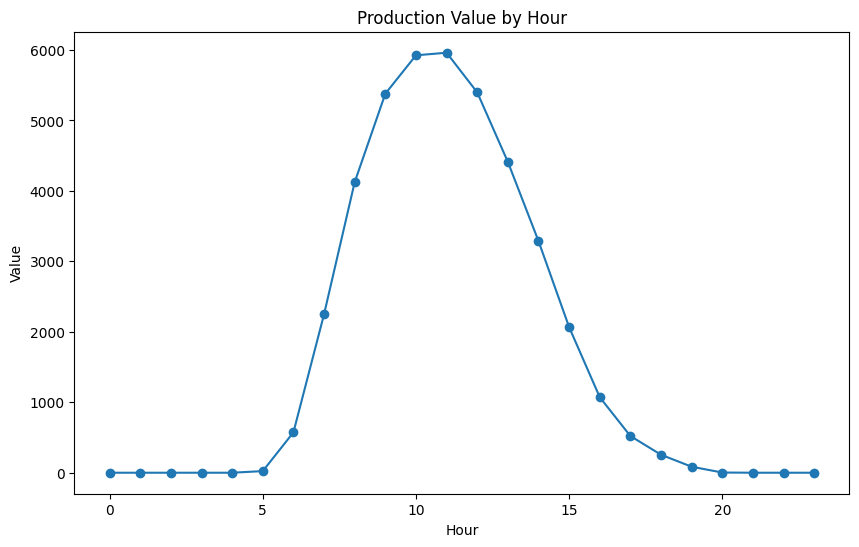

In [15]:
# Ensure the 'date' column is in datetime format
solaredge_df['date'] = pd.to_datetime(solaredge_df['date'])

# Extract hour from the 'date' column
solaredge_df['hour'] = solaredge_df['date'].dt.hour

# Filter the DataFrame for meter_type = 'Production'
filtered_df = solaredge_df[solaredge_df['meter_type'] == 'Production']

# Group by hour and calculate the mean value for each hour (or sum, if appropriate)
hourly_data = filtered_df.groupby('hour')['value'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(hourly_data['hour'], hourly_data['value'], marker='o')

# Adding titles and labels
plt.title('Production Value by Hour')
plt.xlabel('Hour')
plt.ylabel('Value')

# Display the plot
plt.show()


In [16]:
solaredge_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39648 entries, 0 to 39647
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    39648 non-null  datetime64[ns]
 1   meter_type              39648 non-null  object        
 2   value                   28568 non-null  float64       
 3   date_meter_combination  39648 non-null  object        
 4   hour                    39648 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(2)
memory usage: 1.4+ MB


In [17]:
# List the distinct meter types
distinct_meter_types = solaredge_df['meter_type'].unique()

# Display the distinct meter types
print(distinct_meter_types)


['Consumption' 'FeedIn' 'Purchased' 'Production']


#Meter Type Definitions

**Consumption:**

Definition: The total amount of electrical energy used by a household, building, or facility. This includes all the electricity consumed from both the solar production and the grid.
Purpose: Helps to understand the total energy usage, regardless of the source (solar or grid).

**Production:**

Definition: The amount of electrical energy generated by the solar PV (photovoltaic) system. This is the energy produced by your solar panels.
Purpose: Indicates the performance of the solar system and how much energy it contributes to your total consumption.

**Purchased:**

Definition: The amount of electrical energy bought from the grid. This is the energy your system draws from the utility company when the solar production is not sufficient to cover your consumption.
Purpose: Helps track how much energy you rely on from the grid, which directly impacts your utility bills.

**Feed-In:**

Definition: The amount of excess electrical energy generated by the solar system that is not consumed on-site and is fed back into the grid. In some cases, you might receive credit or payment for this excess energy.
Purpose: Indicates how much energy is sent back to the grid, which can reduce overall energy costs if you’re on a net metering plan.

In [18]:
# Ensure the 'date' column is in datetime format if it's not already
solaredge_df['date'] = pd.to_datetime(solaredge_df['date'])

# Filter the DataFrame for the date '2024-08-20' and meter_type 'Consumption'
filtered_df = solaredge_df[(solaredge_df['date'].dt.date == pd.to_datetime('2024-08-01').date()) &
                           (solaredge_df['meter_type'] == 'Consumption')]

# Display the filtered DataFrame
filtered_df


,date,meter_type,value,date_meter_combination,hour
22680,2024-08-01 00:00:00,Consumption,1252.0,2024-08-01 00:00:00_Consumption,0
22681,2024-08-01 01:00:00,Consumption,1247.0,2024-08-01 01:00:00_Consumption,1
22682,2024-08-01 02:00:00,Consumption,1245.0,2024-08-01 02:00:00_Consumption,2
22683,2024-08-01 03:00:00,Consumption,1191.0,2024-08-01 03:00:00_Consumption,3
22684,2024-08-01 04:00:00,Consumption,910.0,2024-08-01 04:00:00_Consumption,4
22685,2024-08-01 05:00:00,Consumption,997.0,2024-08-01 05:00:00_Consumption,5
22686,2024-08-01 06:00:00,Consumption,1737.0,2024-08-01 06:00:00_Consumption,6
22687,2024-08-01 07:00:00,Consumption,1393.0,2024-08-01 07:00:00_Consumption,7
22688,2024-08-01 08:00:00,Consumption,1793.0,2024-08-01 08:00:00_Consumption,8
22689,2024-08-01 09:00:00,Consumption,2062.0,2024-08-01 09:00:00_Consumption,9


In [ ]:
# Ensure the 'date' column is in datetime format if it's not already
solaredge_df['date'] = pd.to_datetime(solaredge_df['date'])

# Filter the DataFrame for the date '2024-08-31' and meter_type 'Consumption'
filtered_df = solaredge_df[(solaredge_df['date'].dt.date == pd.to_datetime('2024-08-31').date()) &
                           (solaredge_df['meter_type'] == 'Consumption')]

# Display the filtered DataFrame
filtered_df

,date,meter_type,value,date_meter_combination,hour
22684,2024-08-31 00:00:00,Consumption,1206.0,2024-08-31 00:00:00_Consumption,0
22685,2024-08-31 01:00:00,Consumption,1259.0,2024-08-31 01:00:00_Consumption,1
22686,2024-08-31 02:00:00,Consumption,1226.0,2024-08-31 02:00:00_Consumption,2
22687,2024-08-31 03:00:00,Consumption,1257.0,2024-08-31 03:00:00_Consumption,3
22688,2024-08-31 04:00:00,Consumption,1343.0,2024-08-31 04:00:00_Consumption,4
22689,2024-08-31 05:00:00,Consumption,1316.0,2024-08-31 05:00:00_Consumption,5
22690,2024-08-31 06:00:00,Consumption,1270.0,2024-08-31 06:00:00_Consumption,6
22691,2024-08-31 07:00:00,Consumption,1601.0,2024-08-31 07:00:00_Consumption,7
22692,2024-08-31 08:00:00,Consumption,2482.0,2024-08-31 08:00:00_Consumption,8
22693,2024-08-31 09:00:00,Consumption,2110.0,2024-08-31 09:00:00_Consumption,9


In [19]:
# Divide the 'value' column by 1000
solaredge_df['value'] = solaredge_df['value'] / 1000

# Display the first few rows to verify the changes
print(solaredge_df.head())


                 date   meter_type  value           date_meter_combination  \
0 2024-01-01 00:00:00  Consumption    NaN  2024-01-01 00:00:00_Consumption   
1 2024-01-01 01:00:00  Consumption    NaN  2024-01-01 01:00:00_Consumption   
2 2024-01-01 02:00:00  Consumption    NaN  2024-01-01 02:00:00_Consumption   
3 2024-01-01 03:00:00  Consumption    NaN  2024-01-01 03:00:00_Consumption   
4 2024-01-01 04:00:00  Consumption    NaN  2024-01-01 04:00:00_Consumption   

   hour  
0     0  
1     1  
2     2  
3     3  
4     4  


In [20]:
# Filter the DataFrame for the date '2024-08-31' and meter_type 'Consumption'
filtered_df = solaredge_df[(solaredge_df['date'].dt.date == pd.to_datetime('2024-08-31').date()) &
                           (solaredge_df['meter_type'] == 'Production')]

# Display the filtered DataFrame
filtered_df

,date,meter_type,value,date_meter_combination,hour
21168,2024-08-31 00:00:00,Production,0.000,2024-08-31 00:00:00_Production,0
21169,2024-08-31 01:00:00,Production,0.000,2024-08-31 01:00:00_Production,1
21170,2024-08-31 02:00:00,Production,0.000,2024-08-31 02:00:00_Production,2
21171,2024-08-31 03:00:00,Production,0.000,2024-08-31 03:00:00_Production,3
21172,2024-08-31 04:00:00,Production,0.000,2024-08-31 04:00:00_Production,4
21173,2024-08-31 05:00:00,Production,0.000,2024-08-31 05:00:00_Production,5
21174,2024-08-31 06:00:00,Production,0.330,2024-08-31 06:00:00_Production,6
21175,2024-08-31 07:00:00,Production,5.957,2024-08-31 07:00:00_Production,7
21176,2024-08-31 08:00:00,Production,9.126,2024-08-31 08:00:00_Production,8
21177,2024-08-31 09:00:00,Production,10.704,2024-08-31 09:00:00_Production,9


In [ ]:
# Define the filename for saving the cleaned data
file_path = "iptv_solaredge_data_cleaned.pkl"

# Save the cleaned DataFrame locally in Codespaces
solaredge_df.to_pickle(file_path)
print(f"✅ Data saved to {file_path}")

# Push the updated file to GitHub
os.system(f"git add {file_path}")
os.system('git commit -m "Updated cleaned SolarEdge data"')
os.system("git push origin main")

print("🚀 Cleaned data pushed to GitHub!")


✅ Data saved to iptv_solaredge_data_cleaned.pkl
[main cdfe6d6] Updated cleaned SolarEdge data
 1 file changed, 0 insertions(+), 0 deletions(-)
🚀 Cleaned data pushed to GitHub!


To https://github.com/AmyHumke12/SolarProject
   d283824..cdfe6d6  main -> main


In [23]:
solaredge_df

,date,meter_type,value,date_meter_combination,hour
0,2024-01-01 00:00:00,Consumption,NaN,2024-01-01 00:00:00_Consumption,0
1,2024-01-01 01:00:00,Consumption,NaN,2024-01-01 01:00:00_Consumption,1
2,2024-01-01 02:00:00,Consumption,NaN,2024-01-01 02:00:00_Consumption,2
3,2024-01-01 03:00:00,Consumption,NaN,2024-01-01 03:00:00_Consumption,3
4,2024-01-01 04:00:00,Consumption,NaN,2024-01-01 04:00:00_Consumption,4
...,...,...,...,...,...
39643,2025-02-16 19:00:00,Production,0.0,2025-02-16 19:00:00_Production,19
39644,2025-02-16 20:00:00,Production,0.0,2025-02-16 20:00:00_Production,20
39645,2025-02-16 21:00:00,Production,0.0,2025-02-16 21:00:00_Production,21
39646,2025-02-16 22:00:00,Production,0.0,2025-02-16 22:00:00_Production,22


#Historical Weather Data
- Historical Source:https://open-meteo.com/en/docs/historical-forecast-api#hourly=temperature_2m,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high
**Key Features of the Code:**
- **Start Date Calculation:**

- If the table is empty, it starts from 2022-01-01 00:00:00.
If data exists, it finds the latest timestamp in the table and starts from the next hour.
- **End Date Calculation:**

- The script continues fetching data until the end of yesterday (end_of_yesterday).

Appending Data:

- Data is appended to the DataFrame, ensuring that the latest data is continuously updated.

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Define the filename for saving weather data
file_path = "iptv_weather_data.pkl"

# Try to load existing weather data if available
if os.path.exists(file_path):
    weather_hourly_dataframe = pd.read_pickle(file_path)
    print("✅ Loaded existing weather data.")
else:
    weather_hourly_dataframe = pd.DataFrame()  # Initialize an empty DataFrame if no file exists
    print("⚠️ No existing weather data found, starting fresh.")

# Determine the start date for fetching new data
if not weather_hourly_dataframe.empty:
    last_date = pd.to_datetime(weather_hourly_dataframe['date'].max())
    start_time_dt = last_date + timedelta(hours=1)
else:
    start_time_dt = datetime(2022, 1, 1, 0, 0, 0)

# Convert start_time_dt to timezone-aware datetime
start_time_dt = start_time_dt.replace(tzinfo=pytz.utc).astimezone(pytz.timezone('America/Chicago'))

# Calculate the end date as 11:59 PM six days before today in Chicago timezone
end_of_six_days_ago = (datetime.now(pytz.timezone('America/Chicago')) - timedelta(days=6)).replace(
    hour=23, minute=59, second=59, microsecond=0
)

# Loop to collect data in monthly increments
while start_time_dt <= end_of_six_days_ago:
    next_month_start = (start_time_dt.replace(day=1) + timedelta(days=32)).replace(day=1)
    end_time_dt = min(next_month_start - timedelta(seconds=1), end_of_six_days_ago)

    start_time = start_time_dt.strftime('%Y-%m-%d')
    end_time = end_time_dt.strftime('%Y-%m-%d')

    print(f"📡 Fetching weather data from {start_time_dt.strftime('%Y-%m-%d %H:%M:%S')} to {end_time_dt.strftime('%Y-%m-%d %H:%M:%S')}")

    # Fetch weather data
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": 42.2871,  # Location-specific latitude
        "longitude": -88.0411,  # Location-specific longitude
        "start_date": start_time,
        "end_date": end_time,
        "hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "precipitation",
                   "snowfall", "snow_depth", "cloud_cover", "cloud_cover_low", "cloud_cover_mid",
                   "cloud_cover_high", "wind_speed_10m", "wind_gusts_10m", "is_day",
                   "sunshine_duration", "global_tilted_irradiance"],
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
        "precipitation_unit": "inch",
        "timezone": "America/Denver",  # API timezone issue workaround
        "tilt": 30,
        "azimuth": 90
    }

    try:
        responses = openmeteo.weather_api(url, params=params)
    except openmeteo_requests.OpenMeteoRequestsError as e:
        print(f"⚠️ Rate limit hit or API issue occurred: {e}. Retrying in 60 seconds...")
        time.sleep(60)
        continue

    response = responses[0]

    # Process hourly data
    hourly = response.Hourly()
    chicago_tz = pytz.timezone('America/Chicago')

    hourly_start_time = pd.to_datetime(hourly.Time(), unit="s", utc=True).tz_convert(chicago_tz)
    hourly_end_time = pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True).tz_convert(chicago_tz)

    hourly_data = {"date": pd.date_range(
        start=hourly_start_time,
        end=hourly_end_time,
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )}

    variable_names = ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "precipitation",
                      "snowfall", "snow_depth", "cloud_cover", "cloud_cover_low", "cloud_cover_mid",
                      "cloud_cover_high", "wind_speed_10m", "wind_gusts_10m", "is_day",
                      "sunshine_duration", "global_tilted_irradiance"]

    for idx, var_name in enumerate(variable_names):
        hourly_data[var_name] = hourly.Variables(idx).ValuesAsNumpy()

    # Create a DataFrame for the current month's data
    monthly_dataframe = pd.DataFrame(data=hourly_data)

    # Ensure no duplicate data is appended
    if not weather_hourly_dataframe.empty:
        existing_timestamps = weather_hourly_dataframe['date']
        new_timestamps = monthly_dataframe['date']
        monthly_dataframe = monthly_dataframe[~new_timestamps.isin(existing_timestamps)]

    if not monthly_dataframe.empty:
        # Append new data to existing DataFrame
        weather_hourly_dataframe = pd.concat([weather_hourly_dataframe, monthly_dataframe], ignore_index=True)
        print(f"✅ Data for {start_time} to {end_time} appended successfully.")
    else:
        print(f"⚠️ No new data to append for {start_time} to {end_time}.")

    # Move to the next month
    start_time_dt = next_month_start

    # Optional: Add a small delay to avoid hitting the API rate limit
    time.sleep(1)

# Save the updated weather data
weather_hourly_dataframe.to_pickle(file_path)
print(f"✅ Weather data saved to {file_path}")

# Push the updated file to GitHub
os.system(f"git add {file_path}")
os.system('git commit -m "Updated weather data"')
os.system("git push origin main")

print("🚀 Weather data pushed to GitHub!")


No existing weather data found, starting fresh.
Fetching weather data from 2021-12-31 18:00:00 to 2022-01-01 17:59:59
Data for 2021-12-31 to 2022-01-01 appended successfully.
Fetching weather data from 2022-01-01 18:00:00 to 2022-02-01 17:59:59
Data for 2022-01-01 to 2022-02-01 appended successfully.
Fetching weather data from 2022-02-01 18:00:00 to 2022-03-01 17:59:59
Data for 2022-02-01 to 2022-03-01 appended successfully.
Fetching weather data from 2022-03-01 18:00:00 to 2022-04-01 17:59:59
Data for 2022-03-01 to 2022-04-01 appended successfully.
Fetching weather data from 2022-04-01 18:00:00 to 2022-05-01 17:59:59
Data for 2022-04-01 to 2022-05-01 appended successfully.
Fetching weather data from 2022-05-01 18:00:00 to 2022-06-01 17:59:59
Data for 2022-05-01 to 2022-06-01 appended successfully.
Fetching weather data from 2022-06-01 18:00:00 to 2022-07-01 17:59:59
Data for 2022-06-01 to 2022-07-01 appended successfully.
Fetching weather data from 2022-07-01 18:00:00 to 2022-08-01 17

To https://github.com/AmyHumke12/SolarProject
   cdfe6d6..af98bc6  main -> main


In [25]:
weather_hourly_dataframe

,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,snowfall,snow_depth,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_gusts_10m,is_day,sunshine_duration,global_tilted_irradiance
0,2021-12-31 01:00:00-06:00,29.179399,92.888649,27.379400,0.0,0.0,0.131234,97.0,97.0,0.0,0.0,6.109918,11.632400,0.0,0.0,0.0
1,2021-12-31 02:00:00-06:00,29.629400,93.591866,28.009399,0.0,0.0,0.131234,99.0,99.0,0.0,0.0,6.105822,11.408700,0.0,0.0,0.0
2,2021-12-31 03:00:00-06:00,29.449400,93.586723,27.829399,0.0,0.0,0.131234,100.0,100.0,0.0,0.0,5.317288,11.184999,0.0,0.0,0.0
3,2021-12-31 04:00:00-06:00,28.729401,94.262344,27.289400,0.0,0.0,0.131234,79.0,79.0,0.0,0.0,3.257121,9.842800,0.0,0.0,0.0
4,2021-12-31 05:00:00-06:00,24.229401,97.033241,23.509399,0.0,0.0,0.131234,99.0,99.0,0.0,0.0,5.592500,7.605800,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27331,2025-02-11 20:00:00-06:00,19.639400,60.584114,8.209400,0.0,0.0,NaN,100.0,56.0,99.0,97.0,8.807788,17.224899,0.0,0.0,0.0
27332,2025-02-11 21:00:00-06:00,20.179399,60.907997,8.839401,0.0,0.0,NaN,100.0,66.0,100.0,93.0,9.596313,18.790798,0.0,0.0,0.0
27333,2025-02-11 22:00:00-06:00,19.999399,62.628445,9.289402,0.0,0.0,NaN,100.0,88.0,100.0,84.0,8.842519,18.790798,0.0,0.0,0.0
27334,2025-02-11 23:00:00-06:00,20.089399,63.147968,9.559399,0.0,0.0,NaN,100.0,84.0,100.0,90.0,8.906659,17.672300,0.0,0.0,0.0


In [26]:
weather_hourly_dataframe.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27336 entries, 0 to 27335
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype                          
---  ------                    --------------  -----                          
 0   date                      27336 non-null  datetime64[ns, America/Chicago]
 1   temperature_2m            27336 non-null  float32                        
 2   relative_humidity_2m      27336 non-null  float32                        
 3   dew_point_2m              27336 non-null  float32                        
 4   precipitation             27336 non-null  float32                        
 5   snowfall                  27336 non-null  float32                        
 6   snow_depth                26825 non-null  float32                        
 7   cloud_cover               27336 non-null  float32                        
 8   cloud_cover_low           27336 non-null  float32                        
 9   cloud_cover_mid  

In [27]:
# Convert the 'date' field to datetime format with nanosecond precision
weather_hourly_dataframe['date'] = pd.to_datetime(weather_hourly_dataframe['date'], errors='coerce')

# Verify the conversion
print(weather_hourly_dataframe.info())
print(weather_hourly_dataframe.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27336 entries, 0 to 27335
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype                          
---  ------                    --------------  -----                          
 0   date                      27336 non-null  datetime64[ns, America/Chicago]
 1   temperature_2m            27336 non-null  float32                        
 2   relative_humidity_2m      27336 non-null  float32                        
 3   dew_point_2m              27336 non-null  float32                        
 4   precipitation             27336 non-null  float32                        
 5   snowfall                  27336 non-null  float32                        
 6   snow_depth                26825 non-null  float32                        
 7   cloud_cover               27336 non-null  float32                        
 8   cloud_cover_low           27336 non-null  float32                        
 9   cloud_cover_mid  

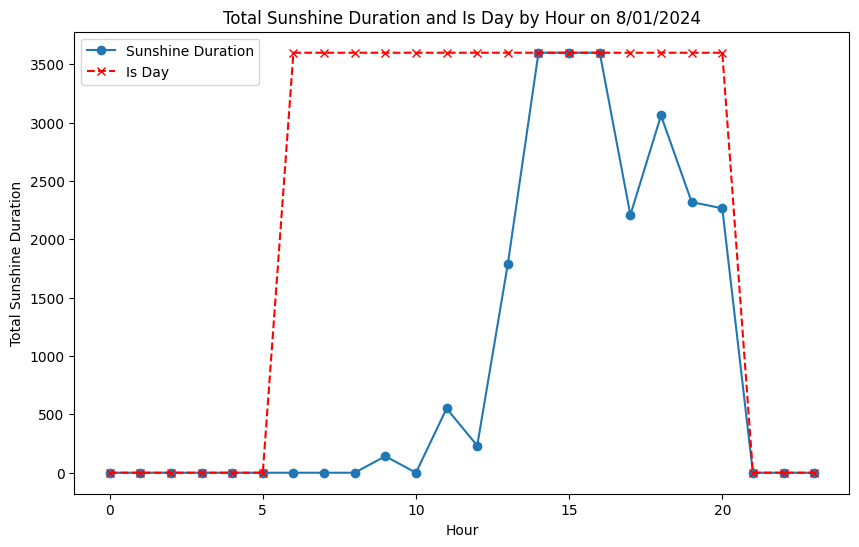

In [28]:
#Show sunshine duration by hours to check date timestamp alignmnet with timezone.
# Filter the DataFrame for the specific date
specific_date = '2024-08-01'
filtered_df = weather_hourly_dataframe[weather_hourly_dataframe['date'].dt.strftime('%Y-%m-%d') == specific_date].copy()

# Extract the hour from the 'date' column
filtered_df['hour'] = filtered_df['date'].dt.hour

# Group by hour and sum the sunshine duration (though for a single day, summing isn't strictly necessary)
hourly_sunshine = filtered_df.groupby('hour')[['sunshine_duration', 'is_day']].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

# Plot sunshine duration
plt.plot(hourly_sunshine['hour'], hourly_sunshine['sunshine_duration'], marker='o', label='Sunshine Duration')

# Plot is_day on the same graph, scaled to the range of sunshine duration
plt.plot(hourly_sunshine['hour'], hourly_sunshine['is_day'] * hourly_sunshine['sunshine_duration'].max(),
         marker='x', linestyle='--', color='red', label='Is Day')

# Adding titles and labels
plt.title('Total Sunshine Duration and Is Day by Hour on 8/01/2024')
plt.xlabel('Hour')
plt.ylabel('Total Sunshine Duration')
plt.legend()

# Display the plot
plt.show()


In [29]:
# Ensure 'date' is in datetime format
weather_hourly_dataframe['date'] = pd.to_datetime(weather_hourly_dataframe['date'])

# Filter the DataFrame for the specific date and select only 'date' and 'is_day' columns
filtered_df = weather_hourly_dataframe.loc[
    weather_hourly_dataframe['date'].dt.strftime('%Y-%m-%d') == '2024-08-01',
    ['date', 'is_day']
]

# Display the filtered DataFrame
print(filtered_df)


                           date  is_day
22654 2024-08-01 00:00:00-05:00     0.0
22655 2024-08-01 01:00:00-05:00     0.0
22656 2024-08-01 02:00:00-05:00     0.0
22657 2024-08-01 03:00:00-05:00     0.0
22658 2024-08-01 04:00:00-05:00     0.0
22659 2024-08-01 05:00:00-05:00     0.0
22660 2024-08-01 06:00:00-05:00     1.0
22661 2024-08-01 07:00:00-05:00     1.0
22662 2024-08-01 08:00:00-05:00     1.0
22663 2024-08-01 09:00:00-05:00     1.0
22664 2024-08-01 10:00:00-05:00     1.0
22665 2024-08-01 11:00:00-05:00     1.0
22666 2024-08-01 12:00:00-05:00     1.0
22667 2024-08-01 13:00:00-05:00     1.0
22668 2024-08-01 14:00:00-05:00     1.0
22669 2024-08-01 15:00:00-05:00     1.0
22670 2024-08-01 16:00:00-05:00     1.0
22671 2024-08-01 17:00:00-05:00     1.0
22672 2024-08-01 18:00:00-05:00     1.0
22673 2024-08-01 19:00:00-05:00     1.0
22674 2024-08-01 20:00:00-05:00     1.0
22675 2024-08-01 21:00:00-05:00     0.0
22676 2024-08-01 22:00:00-05:00     0.0
22677 2024-08-01 23:00:00-05:00     0.0


In [ ]:
## #ONLY IN EMERGENCY - To clear out the existing table so I can start fresh with new data
## Define the filename for weather data
#file_path = "iptv_weather_data.pkl"

## Create an empty DataFrame
#empty_df = pd.DataFrame()

## Save the empty DataFrame, effectively clearing the old data
#empty_df.to_pickle(file_path)

#print(f"✅ The file '{file_path}' has been cleared and replaced with an empty DataFrame.")

## Push the reset file to GitHub
#os.system(f"git add {file_path}")
#os.system('git commit -m "🚨 Reset weather data - Cleared existing table"')
#os.system("git push origin main")

#print("🚀 Reset file pushed to GitHub!")

The weather_data.pkl file has been cleared and replaced with an empty DataFrame.


In [30]:
# Display the min and max date in the DataFrame
min_date = weather_hourly_dataframe['date'].min()
max_date = weather_hourly_dataframe['date'].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")


Minimum date: 2021-12-31 01:00:00-06:00
Maximum date: 2025-02-12 00:00:00-06:00


In [31]:
weather_hourly_dataframe

,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,snowfall,snow_depth,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_gusts_10m,is_day,sunshine_duration,global_tilted_irradiance
0,2021-12-31 01:00:00-06:00,29.179399,92.888649,27.379400,0.0,0.0,0.131234,97.0,97.0,0.0,0.0,6.109918,11.632400,0.0,0.0,0.0
1,2021-12-31 02:00:00-06:00,29.629400,93.591866,28.009399,0.0,0.0,0.131234,99.0,99.0,0.0,0.0,6.105822,11.408700,0.0,0.0,0.0
2,2021-12-31 03:00:00-06:00,29.449400,93.586723,27.829399,0.0,0.0,0.131234,100.0,100.0,0.0,0.0,5.317288,11.184999,0.0,0.0,0.0
3,2021-12-31 04:00:00-06:00,28.729401,94.262344,27.289400,0.0,0.0,0.131234,79.0,79.0,0.0,0.0,3.257121,9.842800,0.0,0.0,0.0
4,2021-12-31 05:00:00-06:00,24.229401,97.033241,23.509399,0.0,0.0,0.131234,99.0,99.0,0.0,0.0,5.592500,7.605800,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27331,2025-02-11 20:00:00-06:00,19.639400,60.584114,8.209400,0.0,0.0,NaN,100.0,56.0,99.0,97.0,8.807788,17.224899,0.0,0.0,0.0
27332,2025-02-11 21:00:00-06:00,20.179399,60.907997,8.839401,0.0,0.0,NaN,100.0,66.0,100.0,93.0,9.596313,18.790798,0.0,0.0,0.0
27333,2025-02-11 22:00:00-06:00,19.999399,62.628445,9.289402,0.0,0.0,NaN,100.0,88.0,100.0,84.0,8.842519,18.790798,0.0,0.0,0.0
27334,2025-02-11 23:00:00-06:00,20.089399,63.147968,9.559399,0.0,0.0,NaN,100.0,84.0,100.0,90.0,8.906659,17.672300,0.0,0.0,0.0


In [32]:
#Duplicates in the dataframe weren't able to be removed via other methods and they did not carry distinct data so just dropped.
# Drop duplicates in place
weather_hourly_dataframe.drop_duplicates(inplace=True)


In [33]:
# Assuming 'date_range' is supposed to be a range of datetimes
weather_hourly_dataframe['date'] = pd.date_range(start="2022-01-01", periods=len(weather_hourly_dataframe), freq='H')


/tmp/ipykernel_2378/851275597.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_hourly_dataframe['date'] = pd.date_range(start="2022-01-01", periods=len(weather_hourly_dataframe), freq='H')


In [34]:
# Find the date_x values that have more than one occurrence
duplicate_date_x = weather_hourly_dataframe['date'].value_counts()

# Filter to keep only those that appear more than once
duplicate_date_x = duplicate_date_x[duplicate_date_x > 1]

# Display the duplicate date_x values
print("Duplicate date_x timestamps (with more than one occurrence):")
print(duplicate_date_x)


Duplicate date_x timestamps (with more than one occurrence):
Series([], Name: count, dtype: int64)


In [35]:
# Define the filename for saving the cleaned weather data
file_path = "iptv_weather_data_cleaned.pkl"

# Save the updated DataFrame locally in Codespaces
weather_hourly_dataframe.to_pickle(file_path)

print(f"✅ Cleaned weather data saved to {file_path}")

# Push the updated file to GitHub
os.system(f"git add {file_path}")
os.system('git commit -m "Updated cleaned weather data"')
os.system("git push origin main")

print("🚀 Cleaned weather data pushed to GitHub!")


✅ Cleaned weather data saved to iptv_weather_data_cleaned.pkl
[main 5ffa2ef] Updated cleaned weather data
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 iptv_weather_data_cleaned.pkl
🚀 Cleaned weather data pushed to GitHub!


To https://github.com/AmyHumke12/SolarProject
   af98bc6..5ffa2ef  main -> main


#Electric Data

In [37]:
# Convert the DATE column to datetime if it's not already in datetime format
electric['DATE'] = pd.to_datetime(electric['DATE'])

# Filter the DataFrame for the specific date '8/23/2024'
filtered_electric = electric[electric['DATE'] == '2024-08-23']

# Display the filtered DataFrame
filtered_electric


,TYPE,DATE,START_TIME,END_TIME,USAGE_(kWh),COST,ESTIMATED_USAGE,NOTES
28842,Electric usage,2024-08-23,0:00,0:29,1.22,$0.07,NaN,NaN
28843,Electric usage,2024-08-23,0:30,0:59,0.48,$0.07,NaN,NaN
28844,Electric usage,2024-08-23,1:00,1:29,0.52,$0.07,NaN,NaN
28845,Electric usage,2024-08-23,1:30,1:59,0.50,$0.07,NaN,NaN
28846,Electric usage,2024-08-23,2:00,2:29,0.50,$0.06,NaN,NaN
28847,Electric usage,2024-08-23,2:30,2:59,0.49,$0.06,NaN,NaN
28848,Electric usage,2024-08-23,3:00,3:29,0.47,$0.07,NaN,NaN
28849,Electric usage,2024-08-23,3:30,3:59,0.47,$0.07,NaN,NaN
28850,Electric usage,2024-08-23,4:00,4:29,0.52,$0.06,NaN,NaN
28851,Electric usage,2024-08-23,4:30,4:59,0.51,$0.08,NaN,NaN


In [38]:
# Step 1: Convert 'DATE' to string and ensure 'START_TIME' is also a string before concatenating
electric['starttimestamp'] = pd.to_datetime(electric['DATE'].astype(str) + ' ' + electric['START_TIME'].astype(str), errors='coerce')

# Step 2: Convert 'DATE' to string and ensure 'END_TIME' is also a string before concatenating
electric['endtimestamp'] = pd.to_datetime(electric['DATE'].astype(str) + ' ' + electric['END_TIME'].astype(str), errors='coerce')

# Step 3: Create 'last_day_month' column with the last day of the month for each date
electric['last_day_month'] = pd.to_datetime(electric['DATE']).dt.to_period('M').dt.to_timestamp('M')

# Display the first few rows to verify
print(electric.head())


             TYPE       DATE START_TIME END_TIME  USAGE_(kWh)    COST  \
0  Electric usage 2023-01-01       0:00     0:29         0.72  $0.00    
1  Electric usage 2023-01-01       0:30     0:59         0.74  $0.00    
2  Electric usage 2023-01-01       1:00     1:29         0.75  $0.00    
3  Electric usage 2023-01-01       1:30     1:59         0.77  $0.00    
4  Electric usage 2023-01-01       2:00     2:29         0.69  $0.00    

   ESTIMATED_USAGE  NOTES      starttimestamp        endtimestamp  \
0              NaN    NaN 2023-01-01 00:00:00 2023-01-01 00:29:00   
1              NaN    NaN 2023-01-01 00:30:00 2023-01-01 00:59:00   
2              NaN    NaN 2023-01-01 01:00:00 2023-01-01 01:29:00   
3              NaN    NaN 2023-01-01 01:30:00 2023-01-01 01:59:00   
4              NaN    NaN 2023-01-01 02:00:00 2023-01-01 02:29:00   

  last_day_month  
0     2023-01-31  
1     2023-01-31  
2     2023-01-31  
3     2023-01-31  
4     2023-01-31  


In [39]:
# Ensure 'START_TIME' is converted to a string before splitting, and fill NaNs with a default value
electric['hour'] = electric['START_TIME'].fillna('00:00').astype(str).str.split(':').str[0].astype(int)

# Display the first few rows to verify
print(electric.head())


             TYPE       DATE START_TIME END_TIME  USAGE_(kWh)    COST  \
0  Electric usage 2023-01-01       0:00     0:29         0.72  $0.00    
1  Electric usage 2023-01-01       0:30     0:59         0.74  $0.00    
2  Electric usage 2023-01-01       1:00     1:29         0.75  $0.00    
3  Electric usage 2023-01-01       1:30     1:59         0.77  $0.00    
4  Electric usage 2023-01-01       2:00     2:29         0.69  $0.00    

   ESTIMATED_USAGE  NOTES      starttimestamp        endtimestamp  \
0              NaN    NaN 2023-01-01 00:00:00 2023-01-01 00:29:00   
1              NaN    NaN 2023-01-01 00:30:00 2023-01-01 00:59:00   
2              NaN    NaN 2023-01-01 01:00:00 2023-01-01 01:29:00   
3              NaN    NaN 2023-01-01 01:30:00 2023-01-01 01:59:00   
4              NaN    NaN 2023-01-01 02:00:00 2023-01-01 02:29:00   

  last_day_month  hour  
0     2023-01-31     0  
1     2023-01-31     0  
2     2023-01-31     1  
3     2023-01-31     1  
4     2023-01-31     

In [40]:
# Function to clean and convert the COST column
def clean_cost(value):
    if isinstance(value, str):
        # Remove dollar sign and commas
        value = value.replace('$', '').replace(',', '')
        # Handle negative values in parentheses
        if '(' in value and ')' in value:
            value = '-' + value.replace('(', '').replace(')', '')
        return float(value)
    else:
        # If the value is already a float, return it as is
        return value

# Apply the cleaning function to the COST column
electric['COST'] = electric['COST'].apply(clean_cost)

# Group by DATE, hour, and last_day_month, then aggregate
electric_agg = electric.groupby(['DATE', 'hour', 'last_day_month']).agg({
    'USAGE_(kWh)': 'sum',
    'COST': 'sum',
    'ESTIMATED_USAGE':'sum'
}).reset_index()

# Create the date_timestamp column
electric_agg['date_timestamp'] = pd.to_datetime(electric_agg['DATE']) + pd.to_timedelta(electric_agg['hour'].astype(int), unit='h')

# Display the new aggregated DataFrame
print(electric_agg.head())

        DATE  hour last_day_month  USAGE_(kWh)  COST  ESTIMATED_USAGE  \
0 2023-01-01     0     2023-01-31         1.46   0.0              0.0   
1 2023-01-01     1     2023-01-31         1.52   0.0              0.0   
2 2023-01-01     2     2023-01-31         1.14   0.0              0.0   
3 2023-01-01     3     2023-01-31         1.64   0.0              0.0   
4 2023-01-01     4     2023-01-31         2.74   0.0              0.0   

       date_timestamp  
0 2023-01-01 00:00:00  
1 2023-01-01 01:00:00  
2 2023-01-01 02:00:00  
3 2023-01-01 03:00:00  
4 2023-01-01 04:00:00  


In [41]:
# Find the date_timestamp values that have more than one occurrence
duplicate_date_x = electric_agg['date_timestamp'].value_counts()

# Filter to keep only those that appear more than once
duplicate_date_x = duplicate_date_x[duplicate_date_x > 1]

# Display the duplicate date_x values
print("Duplicate date_x timestamps (with more than one occurrence):")
print(duplicate_date_x)

Duplicate date_x timestamps (with more than one occurrence):
Series([], Name: count, dtype: int64)


In [42]:
# Ensure the 'DATE' column is in datetime format
electric_agg['DATE'] = pd.to_datetime(electric_agg['DATE'])

# Step 1: Handle division by zero when calculating cost_per_kWh
# Replace zero values in 'USAGE_(kWh)' with np.nan or a small number to avoid division by zero
electric_agg['USAGE_(kWh)'].replace(0, np.nan, inplace=True)

# Step 2: Calculate the cost per unit (kWh)
electric_agg['cost_per_kWh'] = electric_agg['COST'] / electric_agg['USAGE_(kWh)']


# Display the first few rows to inspect the new column
print(electric_agg.head())


        DATE  hour last_day_month  USAGE_(kWh)  COST  ESTIMATED_USAGE  \
0 2023-01-01     0     2023-01-31         1.46   0.0              0.0   
1 2023-01-01     1     2023-01-31         1.52   0.0              0.0   
2 2023-01-01     2     2023-01-31         1.14   0.0              0.0   
3 2023-01-01     3     2023-01-31         1.64   0.0              0.0   
4 2023-01-01     4     2023-01-31         2.74   0.0              0.0   

       date_timestamp  cost_per_kWh  
0 2023-01-01 00:00:00           0.0  
1 2023-01-01 01:00:00           0.0  
2 2023-01-01 02:00:00           0.0  
3 2023-01-01 03:00:00           0.0  
4 2023-01-01 04:00:00           0.0  


/tmp/ipykernel_2378/3631668263.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  electric_agg['USAGE_(kWh)'].replace(0, np.nan, inplace=True)


#Fix the usage data between 1/1/2024-8/24/2024

In [43]:
# Ensure 'DATE' column is in datetime format
electric_agg['DATE'] = pd.to_datetime(electric_agg['DATE'])

# Define the date range
start_date = pd.Timestamp('2024-01-01')
end_date = pd.Timestamp('2024-08-31')

# Replace 'USAGE_(kWh)' with 'ESTIMATED_USAGE' for the specified date range
electric_agg.loc[(electric_agg['DATE'] >= start_date) & (electric_agg['DATE'] <= end_date), 'USAGE_(kWh)'] = electric_agg['ESTIMATED_USAGE']

# Display the first few rows to verify
print(electric_agg[(electric_agg['DATE'] >= start_date) & (electric_agg['DATE'] <= end_date)].head())


           DATE  hour last_day_month  USAGE_(kWh)  COST  ESTIMATED_USAGE  \
8759 2024-01-01     0     2024-01-31         2.38  0.37             2.38   
8760 2024-01-01     1     2024-01-31         2.41  0.54             2.41   
8761 2024-01-01     2     2024-01-31         2.09  0.51             2.09   
8762 2024-01-01     3     2024-01-31         2.55  0.26             2.55   
8763 2024-01-01     4     2024-01-31         5.12  0.24             5.12   

          date_timestamp  cost_per_kWh  
8759 2024-01-01 00:00:00       0.12585  
8760 2024-01-01 01:00:00       0.12500  
8761 2024-01-01 02:00:00       0.12500  
8762 2024-01-01 03:00:00       0.12500  
8763 2024-01-01 04:00:00       0.12766  


/tmp/ipykernel_2378/1188632787.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_usage = electric_agg.resample('M', on='DATE')['USAGE_(kWh)'].sum()


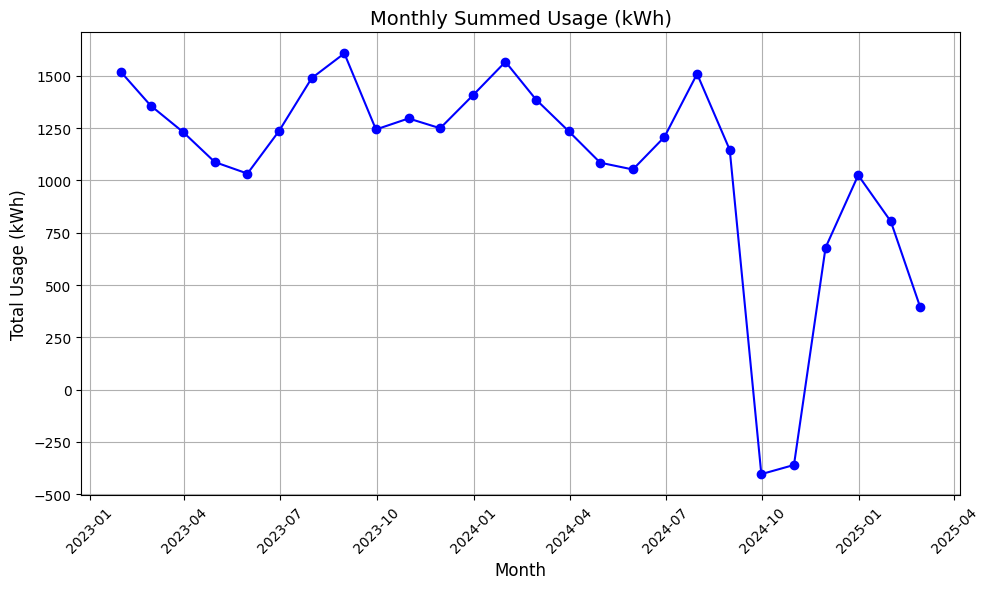

In [44]:
# Ensure 'DATE' is in datetime format
electric_agg['DATE'] = pd.to_datetime(electric_agg['DATE'])

# Step 1: Resample the data by month and sum the 'USAGE_(kWh)'
monthly_usage = electric_agg.resample('M', on='DATE')['USAGE_(kWh)'].sum()

# Step 2: Plot the monthly summed usage
plt.figure(figsize=(10, 6))
plt.plot(monthly_usage.index, monthly_usage.values, marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('Monthly Summed Usage (kWh)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Usage (kWh)', fontsize=12)

# Display the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [46]:
# Define the filename for saving the cleaned electric data
file_path = "iptv_electric_data_cleaned.pkl"

# Save the updated DataFrame locally in Codespaces
electric_agg.to_pickle(file_path)

print(f"✅ Cleaned electric data saved to {file_path}")

# Push the updated file to GitHub
os.system(f"git add {file_path}")
os.system('git commit -m "Updated cleaned electric data"')
os.system("git push origin main")

print("🚀 Cleaned electric data pushed to GitHub!")


✅ Cleaned electric data saved to iptv_electric_data_cleaned.pkl
[main 225b8a8] Updated cleaned electric data
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 iptv_electric_data_cleaned.pkl


🚀 Cleaned electric data pushed to GitHub!


To https://github.com/AmyHumke12/SolarProject
   5ffa2ef..225b8a8  main -> main


#Sun Data
- Identify the hours and dates where the sun is up in northern Illinois
- Also get the angle of the sun and distance it is away from the earth

In [47]:
# Set up location for Mundelein, Illinois
location = LocationInfo("Mundelein", "USA", "America/Chicago", 42.2871, -88.0411)
timezone = pytz.timezone(location.timezone)

# Create an empty list to store the results
daylight_data = []

# Generate data for each day of the year
start_date = datetime(2022, 1, 1)
end_date = datetime(2034, 12, 31)
current_date = start_date

while current_date <= end_date:
    try:
        # Calculate the sun's events for the current date
        sun_info = sun(location.observer, date=current_date)

        # Ensure sunrise and sunset are in the local timezone
        sunrise = sun_info['sunrise'].astimezone(timezone)
        sunset = sun_info['sunset'].astimezone(timezone)

    except ValueError as e:
        print(f"Error for {current_date.date()}: {e}. Defaulting to previous day values if available.")
        sunrise = previous_sunrise if 'previous_sunrise' in locals() else None
        sunset = previous_sunset if 'previous_sunset' in locals() else None

    # Store sunrise and sunset for potential reuse
    previous_sunrise = sunrise
    previous_sunset = sunset

    # Get the sunrise and sunset hours
    sunrise_hour = sunrise.hour if sunrise else None
    sunset_hour = sunset.hour if sunset else None

    # Iterate over each hour of the day
    for hour in range(24):
        current_time = timezone.localize(current_date.replace(hour=hour, minute=0, second=0))
        is_daylight = 0

        if sunrise_hour is not None and sunset_hour is not None:
            if hour == sunrise_hour:
                # Calculate daylight duration within the sunrise hour
                daylight_duration = (60 - sunrise.minute)  # minutes of daylight within the sunrise hour
                if daylight_duration >= 15:
                    is_daylight = 1
            elif hour == sunset_hour:
                # Calculate daylight duration within the sunset hour
                daylight_duration = sunset.minute  # minutes of daylight within the sunset hour
                if daylight_duration >= 15:
                    is_daylight = 1
            elif sunrise_hour < hour < sunset_hour:
                # Set is_daylight to 1 if the current hour is fully between sunrise and sunset
                is_daylight = 1

        # Append the result to the list
        daylight_data.append({
            'date': current_date.date(),
            'hour': hour,
            'is_daylight': is_daylight,
            'solar_angle': elevation(location.observer, current_time),
            'solar_azimuth': azimuth(location.observer, current_time),
            'sunrise_hour': sunrise_hour,
            'sunset_hour': sunset_hour,
            'sunset': sunset,
            'sunrise': sunrise
        })

    current_date += timedelta(days=1)

# Convert the list to a DataFrame
daylight_df = pd.DataFrame(daylight_data)

# Display the rows for 2024-08-01 to check the results
print(daylight_df[daylight_df['date'] == datetime(2024, 8, 1).date()])


Error for 2022-02-21: Unable to find a dusk time on the date specified. Defaulting to previous day values if available.
Error for 2022-03-17: Unable to find a sunset time on the date specified. Defaulting to previous day values if available.
Error for 2023-02-21: Unable to find a dusk time on the date specified. Defaulting to previous day values if available.
Error for 2023-03-17: Unable to find a sunset time on the date specified. Defaulting to previous day values if available.
Error for 2024-02-21: Unable to find a dusk time on the date specified. Defaulting to previous day values if available.
Error for 2024-03-16: Unable to find a sunset time on the date specified. Defaulting to previous day values if available.
Error for 2025-02-20: Unable to find a dusk time on the date specified. Defaulting to previous day values if available.
Error for 2025-03-17: Unable to find a sunset time on the date specified. Defaulting to previous day values if available.
Error for 2026-02-21: Unable to 

In [48]:
# Ensure the 'date' column is in datetime format
daylight_df['date'] = pd.to_datetime(daylight_df['date'])

# Create the 'date_timestamp' column by adding the 'hour' to the 'date'
daylight_df['date_timestamp'] = daylight_df['date'] + pd.to_timedelta(daylight_df['hour'], unit='h')

# Display the updated DataFrame
print(daylight_df.head())


        date  hour  is_daylight  solar_angle  solar_azimuth  sunrise_hour  \
0 2022-01-01     0            0   -70.688555       3.056930             7   
1 2022-01-01     1            0   -66.512771      39.814783             7   
2 2022-01-01     2            0   -57.778016      63.069547             7   
3 2022-01-01     3            0   -47.315025      78.020430             7   
4 2022-01-01     4            0   -36.299107      89.240580             7   

   sunset_hour                           sunset  \
0           16 2022-01-01 16:30:21.838422-06:00   
1           16 2022-01-01 16:30:21.838422-06:00   
2           16 2022-01-01 16:30:21.838422-06:00   
3           16 2022-01-01 16:30:21.838422-06:00   
4           16 2022-01-01 16:30:21.838422-06:00   

                           sunrise      date_timestamp  
0 2022-01-01 07:21:28.269561-06:00 2022-01-01 00:00:00  
1 2022-01-01 07:21:28.269561-06:00 2022-01-01 01:00:00  
2 2022-01-01 07:21:28.269561-06:00 2022-01-01 02:00:00  
3 

In [49]:
# Find the date_x values that have more than one occurrence
duplicate_date_x = daylight_df['date_timestamp'].value_counts()

# Filter to keep only those that appear more than once
duplicate_date_x = duplicate_date_x[duplicate_date_x > 1]

# Display the duplicate date_x values
print("Duplicate date_x timestamps (with more than one occurrence):")
print(duplicate_date_x)

Duplicate date_x timestamps (with more than one occurrence):
Series([], Name: count, dtype: int64)


In [50]:
daylight_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype                          
---  ------          --------------   -----                          
 0   date            113952 non-null  datetime64[ns]                 
 1   hour            113952 non-null  int64                          
 2   is_daylight     113952 non-null  int64                          
 3   solar_angle     113952 non-null  float64                        
 4   solar_azimuth   113952 non-null  float64                        
 5   sunrise_hour    113952 non-null  int64                          
 6   sunset_hour     113952 non-null  int64                          
 7   sunset          113952 non-null  datetime64[ns, America/Chicago]
 8   sunrise         113952 non-null  datetime64[ns, America/Chicago]
 9   date_timestamp  113952 non-null  datetime64[ns]                 
dtypes: datetime64[ns, America/Chicago](2), datet

In [51]:
# Define the filename
file_path = "iptv_daylight_df.pkl"

# Save DataFrame locally
daylight_df.to_pickle(file_path)
print(f"✅ Daylight data saved to {file_path}")

# Push to GitHub
os.system(f"git add {file_path}")
os.system('git commit -m "Updated daylight data"')
os.system("git push origin main")
print("🚀 Daylight data pushed to GitHub!")


✅ Daylight data saved to iptv_daylight_df.pkl
[main 621deb8] Updated daylight data
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 iptv_daylight_df.pkl
🚀 Daylight data pushed to GitHub!


To https://github.com/AmyHumke12/SolarProject
   225b8a8..621deb8  main -> main


#Check the hour and time alignment

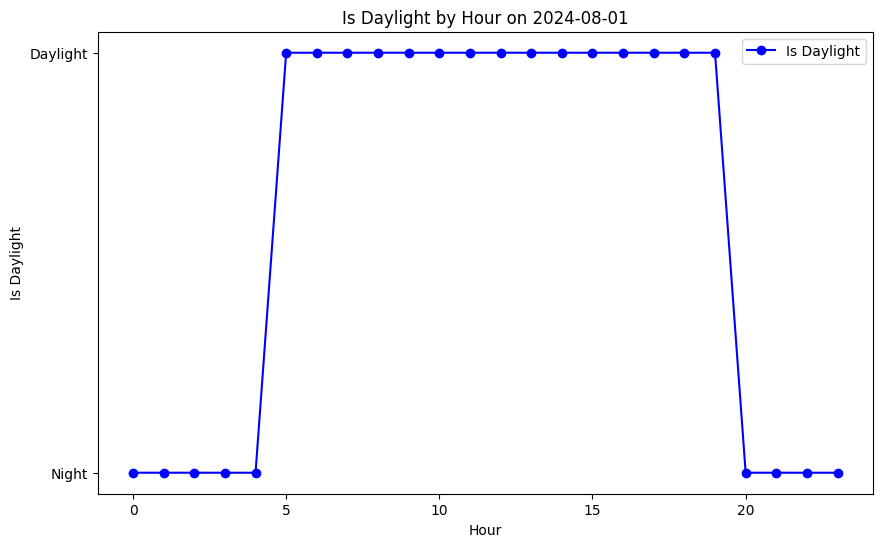

In [52]:
# Filter the daylight_df for the specific date and create a copy
specific_date = '2024-08-01'
filtered_daylight_df = daylight_df[daylight_df['date'].dt.strftime('%Y-%m-%d') == specific_date].copy()

# Plotting
plt.figure(figsize=(10, 6))

# Plot is_daylight against the hour
plt.plot(filtered_daylight_df['hour'], filtered_daylight_df['is_daylight'], marker='o', linestyle='-', color='blue', label='Is Daylight')

# Adding titles and labels
plt.title('Is Daylight by Hour on 2024-08-01')
plt.xlabel('Hour')
plt.ylabel('Is Daylight')
plt.yticks([0, 1], ['Night', 'Daylight'])
plt.legend()

# Display the plot
plt.show()


In [53]:
# Check the data type of the 'date' column
print(weather_hourly_dataframe['date'].dtype)

# Display the first few rows of the 'date' column
print(weather_hourly_dataframe['date'].head())


datetime64[ns]
0   2022-01-01 00:00:00
1   2022-01-01 01:00:00
2   2022-01-01 02:00:00
3   2022-01-01 03:00:00
4   2022-01-01 04:00:00
Name: date, dtype: datetime64[ns]


In [54]:
# Attempt to force the conversion to datetime
weather_hourly_dataframe['date'] = pd.to_datetime(weather_hourly_dataframe['date'], errors='coerce')

# Check for any null values that may have resulted from failed conversions
print(weather_hourly_dataframe[weather_hourly_dataframe['date'].isnull()])


Empty DataFrame
Columns: [date, temperature_2m, relative_humidity_2m, dew_point_2m, precipitation, snowfall, snow_depth, cloud_cover, cloud_cover_low, cloud_cover_mid, cloud_cover_high, wind_speed_10m, wind_gusts_10m, is_day, sunshine_duration, global_tilted_irradiance]
Index: []


#Add the sun data to the historical weather data and save again

In [55]:
weather_hourly_dataframe.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27336 entries, 0 to 27335
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      27336 non-null  datetime64[ns]
 1   temperature_2m            27336 non-null  float32       
 2   relative_humidity_2m      27336 non-null  float32       
 3   dew_point_2m              27336 non-null  float32       
 4   precipitation             27336 non-null  float32       
 5   snowfall                  27336 non-null  float32       
 6   snow_depth                26825 non-null  float32       
 7   cloud_cover               27336 non-null  float32       
 8   cloud_cover_low           27336 non-null  float32       
 9   cloud_cover_mid           27336 non-null  float32       
 10  cloud_cover_high          27336 non-null  float32       
 11  wind_speed_10m            27336 non-null  float32       
 12  wind_gusts_10m    

In [56]:
weather_hourly_dataframe

,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,snowfall,snow_depth,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_gusts_10m,is_day,sunshine_duration,global_tilted_irradiance
0,2022-01-01 00:00:00,29.179399,92.888649,27.379400,0.0,0.0,0.131234,97.0,97.0,0.0,0.0,6.109918,11.632400,0.0,0.0,0.0
1,2022-01-01 01:00:00,29.629400,93.591866,28.009399,0.0,0.0,0.131234,99.0,99.0,0.0,0.0,6.105822,11.408700,0.0,0.0,0.0
2,2022-01-01 02:00:00,29.449400,93.586723,27.829399,0.0,0.0,0.131234,100.0,100.0,0.0,0.0,5.317288,11.184999,0.0,0.0,0.0
3,2022-01-01 03:00:00,28.729401,94.262344,27.289400,0.0,0.0,0.131234,79.0,79.0,0.0,0.0,3.257121,9.842800,0.0,0.0,0.0
4,2022-01-01 04:00:00,24.229401,97.033241,23.509399,0.0,0.0,0.131234,99.0,99.0,0.0,0.0,5.592500,7.605800,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27331,2025-02-12 19:00:00,19.639400,60.584114,8.209400,0.0,0.0,NaN,100.0,56.0,99.0,97.0,8.807788,17.224899,0.0,0.0,0.0
27332,2025-02-12 20:00:00,20.179399,60.907997,8.839401,0.0,0.0,NaN,100.0,66.0,100.0,93.0,9.596313,18.790798,0.0,0.0,0.0
27333,2025-02-12 21:00:00,19.999399,62.628445,9.289402,0.0,0.0,NaN,100.0,88.0,100.0,84.0,8.842519,18.790798,0.0,0.0,0.0
27334,2025-02-12 22:00:00,20.089399,63.147968,9.559399,0.0,0.0,NaN,100.0,84.0,100.0,90.0,8.906659,17.672300,0.0,0.0,0.0


In [57]:
# Ensure 'date' columns are in datetime format and timezone-naive
weather_hourly_dataframe['date'] = pd.to_datetime(weather_hourly_dataframe['date']).dt.tz_localize(None)
daylight_df['date_timestamp'] = pd.to_datetime(daylight_df['date_timestamp']).dt.tz_localize(None)

# Optional: Round to nearest hour
weather_hourly_dataframe['date_rounded'] = weather_hourly_dataframe['date'].dt.floor('H')
daylight_df['date_timestamp_rounded'] = daylight_df['date_timestamp'].dt.floor('H')

# Perform the merge on the rounded datetime columns
merged_weather_df = pd.merge(weather_hourly_dataframe, daylight_df, left_on='date_rounded', right_on='date_timestamp_rounded', how='left')

# Drop duplicate or unnecessary columns after the merge
merged_weather_df.drop(columns=['date_y', 'date_rounded', 'date_timestamp_rounded'], inplace=True, errors='ignore')

# Display a sample of the merged DataFrame to check the results
print(merged_weather_df.head())



               date_x  temperature_2m  relative_humidity_2m  dew_point_2m  \
0 2022-01-01 00:00:00       29.179399             92.888649     27.379400   
1 2022-01-01 01:00:00       29.629400             93.591866     28.009399   
2 2022-01-01 02:00:00       29.449400             93.586723     27.829399   
3 2022-01-01 03:00:00       28.729401             94.262344     27.289400   
4 2022-01-01 04:00:00       24.229401             97.033241     23.509399   

   precipitation  snowfall  snow_depth  cloud_cover  cloud_cover_low  \
0            0.0       0.0    0.131234         97.0             97.0   
1            0.0       0.0    0.131234         99.0             99.0   
2            0.0       0.0    0.131234        100.0            100.0   
3            0.0       0.0    0.131234         79.0             79.0   
4            0.0       0.0    0.131234         99.0             99.0   

   cloud_cover_mid  ...  global_tilted_irradiance  hour  is_daylight  \
0              0.0  ...         

/tmp/ipykernel_2378/3741016986.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_hourly_dataframe['date_rounded'] = weather_hourly_dataframe['date'].dt.floor('H')
/tmp/ipykernel_2378/3741016986.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  daylight_df['date_timestamp_rounded'] = daylight_df['date_timestamp'].dt.floor('H')


In [58]:
merged_weather_df

,date_x,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,snowfall,snow_depth,cloud_cover,cloud_cover_low,cloud_cover_mid,...,global_tilted_irradiance,hour,is_daylight,solar_angle,solar_azimuth,sunrise_hour,sunset_hour,sunset,sunrise,date_timestamp
0,2022-01-01 00:00:00,29.179399,92.888649,27.379400,0.0,0.0,0.131234,97.0,97.0,0.0,...,0.0,0,0,-70.688555,3.056930,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 00:00:00
1,2022-01-01 01:00:00,29.629400,93.591866,28.009399,0.0,0.0,0.131234,99.0,99.0,0.0,...,0.0,1,0,-66.512771,39.814783,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 01:00:00
2,2022-01-01 02:00:00,29.449400,93.586723,27.829399,0.0,0.0,0.131234,100.0,100.0,0.0,...,0.0,2,0,-57.778016,63.069547,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 02:00:00
3,2022-01-01 03:00:00,28.729401,94.262344,27.289400,0.0,0.0,0.131234,79.0,79.0,0.0,...,0.0,3,0,-47.315025,78.020430,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 03:00:00
4,2022-01-01 04:00:00,24.229401,97.033241,23.509399,0.0,0.0,0.131234,99.0,99.0,0.0,...,0.0,4,0,-36.299107,89.240580,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27331,2025-02-12 19:00:00,19.639400,60.584114,8.209400,0.0,0.0,NaN,100.0,56.0,99.0,...,0.0,19,0,-18.770509,268.864556,6,17,2025-02-12 17:20:58.582971-06:00,2025-02-12 06:52:20.688947-06:00,2025-02-12 19:00:00
27332,2025-02-12 20:00:00,20.179399,60.907997,8.839401,0.0,0.0,NaN,100.0,66.0,100.0,...,0.0,20,0,-29.822438,279.360892,6,17,2025-02-12 17:20:58.582971-06:00,2025-02-12 06:52:20.688947-06:00,2025-02-12 20:00:00
27333,2025-02-12 21:00:00,19.999399,62.628445,9.289402,0.0,0.0,NaN,100.0,88.0,100.0,...,0.0,21,0,-40.501070,291.588175,6,17,2025-02-12 17:20:58.582971-06:00,2025-02-12 06:52:20.688947-06:00,2025-02-12 21:00:00
27334,2025-02-12 22:00:00,20.089399,63.147968,9.559399,0.0,0.0,NaN,100.0,84.0,100.0,...,0.0,22,0,-50.164176,307.253967,6,17,2025-02-12 17:20:58.582971-06:00,2025-02-12 06:52:20.688947-06:00,2025-02-12 22:00:00


In [59]:
merged_weather_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27336 entries, 0 to 27335
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype                          
---  ------                    --------------  -----                          
 0   date_x                    27336 non-null  datetime64[ns]                 
 1   temperature_2m            27336 non-null  float32                        
 2   relative_humidity_2m      27336 non-null  float32                        
 3   dew_point_2m              27336 non-null  float32                        
 4   precipitation             27336 non-null  float32                        
 5   snowfall                  27336 non-null  float32                        
 6   snow_depth                26825 non-null  float32                        
 7   cloud_cover               27336 non-null  float32                        
 8   cloud_cover_low           27336 non-null  float32                        
 9   cloud_cover_mid  

###There are a few time slots missing weather information, fill them with the value from the hour before it.

In [60]:
# First, sort the DataFrame by the 'date_x' column to ensure proper order
merged_weather_df = merged_weather_df.sort_values(by='date_x')

# Then, fill null values in the specified columns with the value from the previous row using ffill()
merged_weather_df[['temperature_2m', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high']] = merged_weather_df[['temperature_2m', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high']].ffill()

# Display the first few rows of the DataFrame to verify the changes
print(merged_weather_df.head())


               date_x  temperature_2m  relative_humidity_2m  dew_point_2m  \
0 2022-01-01 00:00:00       29.179399             92.888649     27.379400   
1 2022-01-01 01:00:00       29.629400             93.591866     28.009399   
2 2022-01-01 02:00:00       29.449400             93.586723     27.829399   
3 2022-01-01 03:00:00       28.729401             94.262344     27.289400   
4 2022-01-01 04:00:00       24.229401             97.033241     23.509399   

   precipitation  snowfall  snow_depth  cloud_cover  cloud_cover_low  \
0            0.0       0.0    0.131234         97.0             97.0   
1            0.0       0.0    0.131234         99.0             99.0   
2            0.0       0.0    0.131234        100.0            100.0   
3            0.0       0.0    0.131234         79.0             79.0   
4            0.0       0.0    0.131234         99.0             99.0   

   cloud_cover_mid  ...  global_tilted_irradiance  hour  is_daylight  \
0              0.0  ...         

                 date_x  hour  is_daylight  is_day
16  2022-01-01 16:00:00    16            1     0.0
40  2022-01-02 16:00:00    16            1     0.0
64  2022-01-03 16:00:00    16            1     0.0
88  2022-01-04 16:00:00    16            1     0.0
112 2022-01-05 16:00:00    16            1     0.0
136 2022-01-06 16:00:00    16            1     0.0
160 2022-01-07 16:00:00    16            1     0.0
184 2022-01-08 16:00:00    16            1     0.0
208 2022-01-09 16:00:00    16            1     0.0
232 2022-01-10 16:00:00    16            1     0.0
256 2022-01-11 16:00:00    16            1     0.0
280 2022-01-12 16:00:00    16            1     0.0
304 2022-01-13 16:00:00    16            1     0.0
328 2022-01-14 16:00:00    16            1     0.0
352 2022-01-15 16:00:00    16            1     0.0
376 2022-01-16 16:00:00    16            1     0.0
400 2022-01-17 16:00:00    16            1     0.0
424 2022-01-18 16:00:00    16            1     0.0
448 2022-01-19 16:00:00    16  

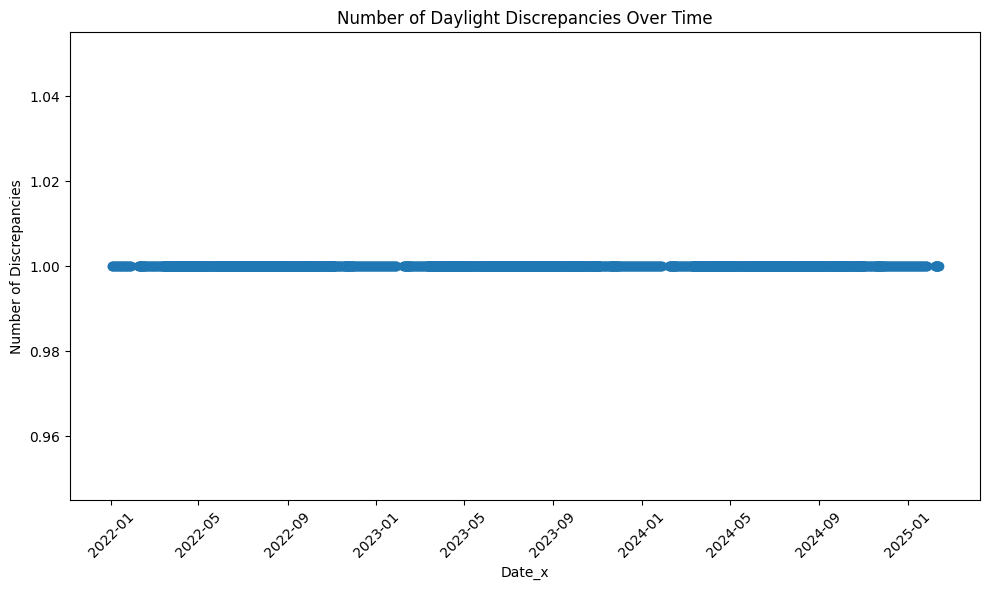

In [61]:
# Filter the DataFrame to find where is_daylight and is_day do not match
discrepancies_df = merged_weather_df[merged_weather_df['is_daylight'] != merged_weather_df['is_day']]

# Display the first few rows to inspect the discrepancies
print(discrepancies_df[['date_x', 'hour', 'is_daylight', 'is_day']].head(20))



# You might want to count the number of discrepancies per day to get an overview
discrepancy_summary = discrepancies_df.groupby(['date_x']).size().reset_index(name='discrepancy_count')
print(discrepancy_summary)

# If you want to visualize the discrepancies over time:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(discrepancy_summary['date_x'], discrepancy_summary['discrepancy_count'], marker='o', linestyle='-')
plt.title('Number of Daylight Discrepancies Over Time')
plt.xlabel('Date_x')
plt.ylabel('Number of Discrepancies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


                   date_x  hour  is_day  is_daylight
16    2022-01-01 16:00:00    16     0.0            1
40    2022-01-02 16:00:00    16     0.0            1
64    2022-01-03 16:00:00    16     0.0            1
88    2022-01-04 16:00:00    16     0.0            1
112   2022-01-05 16:00:00    16     0.0            1
...                   ...   ...     ...          ...
27281 2025-02-10 17:00:00    17     0.0            1
27294 2025-02-11 06:00:00     6     1.0            0
27305 2025-02-11 17:00:00    17     0.0            1
27318 2025-02-12 06:00:00     6     1.0            0
27329 2025-02-12 17:00:00    17     0.0            1

[2558 rows x 4 columns]


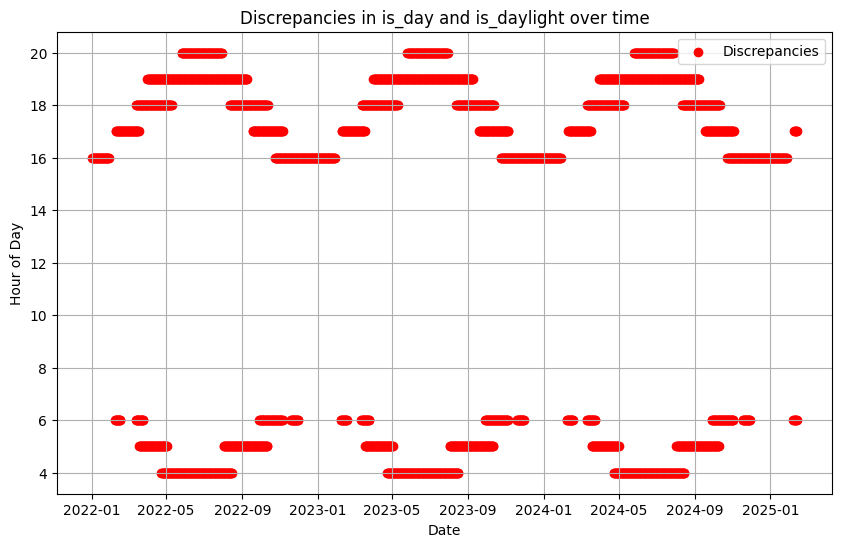

                   date_x  temperature_2m  relative_humidity_2m  dew_point_2m  \
22636 2024-08-01 04:00:00       69.679398             93.145836     67.609398   
22651 2024-08-01 19:00:00       78.589401             78.623283     71.389397   

       precipitation  snowfall  snow_depth  cloud_cover  cloud_cover_low  \
22636            0.0       0.0         NaN         98.0              0.0   
22651            0.0       0.0         NaN         11.0              2.0   

       cloud_cover_mid  ...  global_tilted_irradiance  hour  is_daylight  \
22636              0.0  ...                   0.94641     4            0   
22651              1.0  ...                   0.00000    19            1   

       solar_angle  solar_azimuth  sunrise_hour  sunset_hour  \
22636   -16.747478      45.036705             5           20   
22651    11.593372     283.518630             5           20   

                                sunset                          sunrise  \
22636 2024-07-31 20:11:40.7057

In [62]:
# Filter the merged_weather_df to get only the rows with discrepancies
discrepancies_df = merged_weather_df[merged_weather_df['is_day'] != merged_weather_df['is_daylight']]

# Display the discrepancies to help analyze them
print(discrepancies_df[['date_x', 'hour', 'is_day', 'is_daylight']])

# Visualize the discrepancies over time
plt.figure(figsize=(10, 6))
plt.scatter(discrepancies_df['date_x'], discrepancies_df['hour'], c='red', label='Discrepancies')
plt.title('Discrepancies in is_day and is_daylight over time')
plt.xlabel('Date')
plt.ylabel('Hour of Day')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, focus on a specific date range to analyze
specific_date_range = discrepancies_df[(discrepancies_df['date_x'] >= '2024-08-01') & (discrepancies_df['date_x'] <= '2024-08-02')]
print(specific_date_range)


In [63]:
# Display a sample of the full merged DataFrame to inspect values directly to see why the is daylight and is day fields do not line up.
#Looking at this it seems the astral numbers are correct so going to use that and not the other.
print(merged_weather_df[['date_x', 'hour', 'is_day', 'is_daylight', 'sunrise', 'sunset']].head(100))

# Optionally, check if there are any discrepancies at all
discrepancies_exist = merged_weather_df['is_day'] != merged_weather_df['is_daylight']
if discrepancies_exist.any():
    discrepancies_df = merged_weather_df[discrepancies_exist]
    print(discrepancies_df[['date_x', 'hour', 'is_day', 'is_daylight', 'sunrise', 'sunset']])
else:
    print("No discrepancies found between is_day and is_daylight.")


                date_x  hour  is_day  is_daylight  \
0  2022-01-01 00:00:00     0     0.0            0   
1  2022-01-01 01:00:00     1     0.0            0   
2  2022-01-01 02:00:00     2     0.0            0   
3  2022-01-01 03:00:00     3     0.0            0   
4  2022-01-01 04:00:00     4     0.0            0   
..                 ...   ...     ...          ...   
95 2022-01-04 23:00:00    23     0.0            0   
96 2022-01-05 00:00:00     0     0.0            0   
97 2022-01-05 01:00:00     1     0.0            0   
98 2022-01-05 02:00:00     2     0.0            0   
99 2022-01-05 03:00:00     3     0.0            0   

                            sunrise                           sunset  
0  2022-01-01 07:21:28.269561-06:00 2022-01-01 16:30:21.838422-06:00  
1  2022-01-01 07:21:28.269561-06:00 2022-01-01 16:30:21.838422-06:00  
2  2022-01-01 07:21:28.269561-06:00 2022-01-01 16:30:21.838422-06:00  
3  2022-01-01 07:21:28.269561-06:00 2022-01-01 16:30:21.838422-06:00  
4  2022-

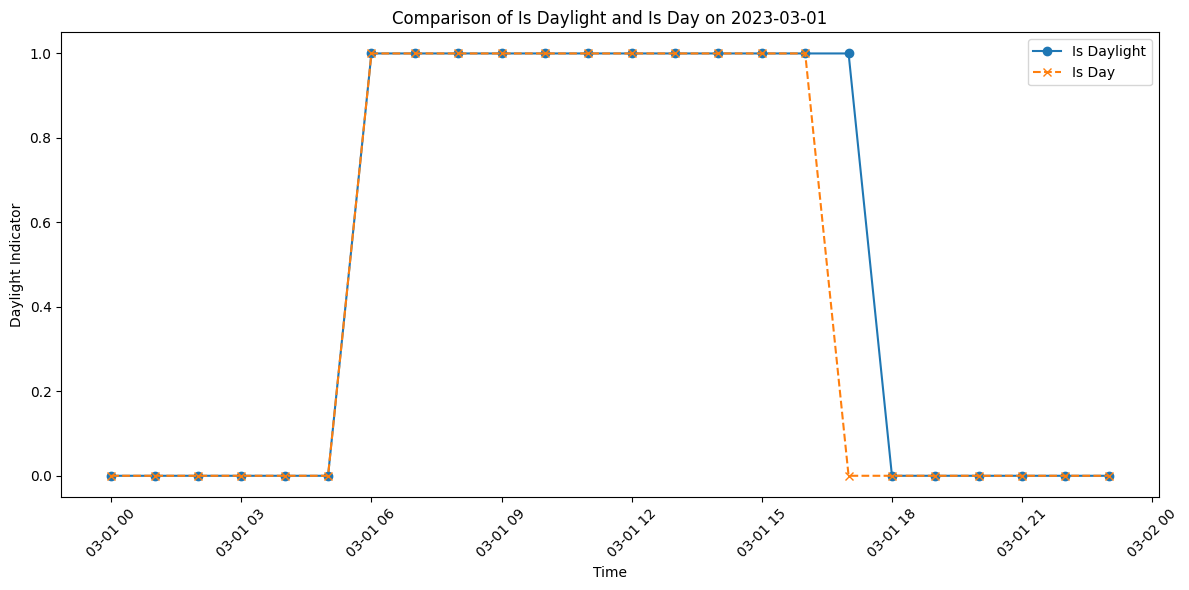

In [64]:
# Filter the data for a specific day to visualize the discrepancies
specific_date = '2023-03-01'
discrepancy_df = merged_weather_df[merged_weather_df['date_x'].dt.strftime('%Y-%m-%d') == specific_date]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(discrepancy_df['date_x'], discrepancy_df['is_daylight'], label='Is Daylight', marker='o', linestyle='-')
plt.plot(discrepancy_df['date_x'], discrepancy_df['is_day'], label='Is Day', marker='x', linestyle='--')

# Adding titles and labels
plt.title(f'Comparison of Is Daylight and Is Day on {specific_date}')
plt.xlabel('Time')
plt.ylabel('Daylight Indicator')
plt.legend()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


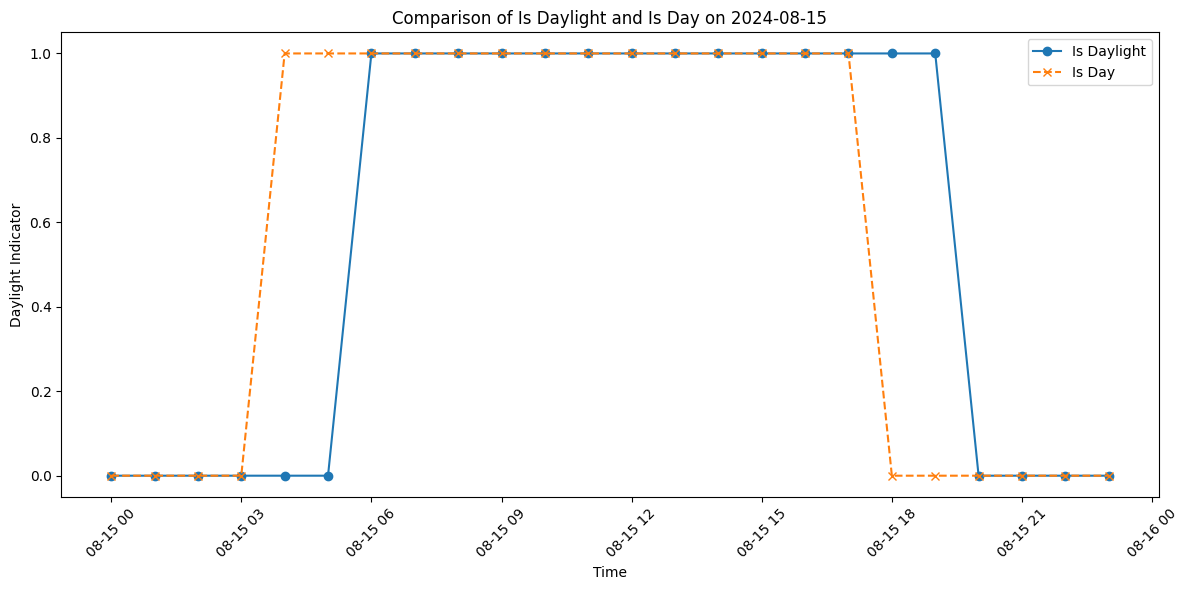

In [65]:
# Filter the data for a specific day to visualize the discrepancies
specific_date = '2024-08-15'
discrepancy_df = merged_weather_df[merged_weather_df['date_x'].dt.strftime('%Y-%m-%d') == specific_date]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(discrepancy_df['date_x'], discrepancy_df['is_daylight'], label='Is Daylight', marker='o', linestyle='-')
plt.plot(discrepancy_df['date_x'], discrepancy_df['is_day'], label='Is Day', marker='x', linestyle='--')

# Adding titles and labels
plt.title(f'Comparison of Is Daylight and Is Day on {specific_date}')
plt.xlabel('Time')
plt.ylabel('Daylight Indicator')
plt.legend()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


#Drop is_day from the dataframe because it is not reliable.
- I suspect because the time zone was incorrect on the weather data, the is_day identifier is also off.
- Not going to use is_day

In [66]:
# Drop the 'is_day' column from merged_weather_df
merged_weather_df.drop(columns=['is_day'], inplace=True)




In [67]:
# Verify the column has been dropped
merged_weather_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27336 entries, 0 to 27335
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype                          
---  ------                    --------------  -----                          
 0   date_x                    27336 non-null  datetime64[ns]                 
 1   temperature_2m            27336 non-null  float32                        
 2   relative_humidity_2m      27336 non-null  float32                        
 3   dew_point_2m              27336 non-null  float32                        
 4   precipitation             27336 non-null  float32                        
 5   snowfall                  27336 non-null  float32                        
 6   snow_depth                26825 non-null  float32                        
 7   cloud_cover               27336 non-null  float32                        
 8   cloud_cover_low           27336 non-null  float32                        
 9   cloud_cover_mid  

In [68]:
# Define the filename
file_path = "iptv_weather_data_final.pkl"

# Save DataFrame locally
merged_weather_df.to_pickle(file_path)
print(f"✅ Weather data saved to {file_path}")

# Push to GitHub
os.system(f"git add {file_path}")
os.system('git commit -m "Updated final weather data"')
os.system("git push origin main")
print("🚀 Final weather data pushed to GitHub!")


✅ Weather data saved to iptv_weather_data_final.pkl
[main b8497b2] Updated final weather data
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 iptv_weather_data_final.pkl
🚀 Final weather data pushed to GitHub!


To https://github.com/AmyHumke12/SolarProject
   621deb8..b8497b2  main -> main


#Populate Future State Weather.
- Populate the future weather with the actual weather that happened in each historical Month/Day/Hour match.

In [69]:
# Step 1: Exclude astro fields from median calculation
columns_to_exclude = ['is_daylight', 'solar_angle', 'solar_azimuth', 'sunrise_hour',
                      'sunset_hour', 'sunset', 'sunrise', 'date_timestamp', 'data_type']

numeric_columns = merged_weather_df.select_dtypes(include=['number']).columns.difference(columns_to_exclude).tolist()

# Step 2: Create 'day_hour' for mapping
merged_weather_df['day_hour'] = merged_weather_df['date_timestamp'].dt.strftime('%m-%d %H')
day_hour_medians = merged_weather_df.groupby('day_hour')[numeric_columns].median()

# Step 3: Prepare the future weather DataFrame by filtering from daylight_df
last_historical_date = merged_weather_df['date_timestamp'].max()
future_weather_df = daylight_df[daylight_df['date_timestamp'] > last_historical_date].copy()

# Step 4: Create 'day_hour' for future data and map historical medians
future_weather_df['day_hour'] = future_weather_df['date_timestamp'].dt.strftime('%m-%d %H')

# Populate future data using historical medians
for column in numeric_columns:
    future_weather_df[column] = future_weather_df['day_hour'].map(day_hour_medians[column])

# Step 5: Fill any NaN values (if no exact day_hour match is found)
for column in numeric_columns:
    future_weather_df[column].fillna(merged_weather_df[column].median(), inplace=True)

# Step 6: Mark original data as 'actual' and future data as 'estimated'
merged_weather_df['data_type'] = 'actual'
future_weather_df['data_type'] = 'estimated'

# Step 7: Concatenate the historical and future data
final_df = pd.concat([merged_weather_df, future_weather_df], ignore_index=True)

# Step 8: Verify the date range of the final DataFrame
min_max_dates = {
    'date_x': {
        'min': final_df['date_x'].min(),
        'max': final_df['date_x'].max()
    },
    'date_timestamp': {
        'min': final_df['date_timestamp'].min(),
        'max': final_df['date_timestamp'].max()
    }
}

min_max_dates_df = pd.DataFrame(min_max_dates)
print(min_max_dates_df)
final_df


                 date_x      date_timestamp
min 2022-01-01 00:00:00 2022-01-01 00:00:00
max 2025-02-12 23:00:00 2034-12-31 23:00:00


/tmp/ipykernel_2378/4238037781.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future_weather_df[column].fillna(merged_weather_df[column].median(), inplace=True)
/tmp/ipykernel_2378/4238037781.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col

,date_x,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,snowfall,snow_depth,cloud_cover,cloud_cover_low,cloud_cover_mid,...,solar_azimuth,sunrise_hour,sunset_hour,sunset,sunrise,date_timestamp,day_hour,data_type,date,date_timestamp_rounded
0,2022-01-01 00:00:00,29.179399,92.888649,27.379400,0.0,0.0,0.131234,97.0,97.0,0.0,...,3.056930,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 00:00:00,01-01 00,actual,NaT,NaT
1,2022-01-01 01:00:00,29.629400,93.591866,28.009399,0.0,0.0,0.131234,99.0,99.0,0.0,...,39.814783,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 01:00:00,01-01 01,actual,NaT,NaT
2,2022-01-01 02:00:00,29.449400,93.586723,27.829399,0.0,0.0,0.131234,100.0,100.0,0.0,...,63.069547,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 02:00:00,01-01 02,actual,NaT,NaT
3,2022-01-01 03:00:00,28.729401,94.262344,27.289400,0.0,0.0,0.131234,79.0,79.0,0.0,...,78.020430,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 03:00:00,01-01 03,actual,NaT,NaT
4,2022-01-01 04:00:00,24.229401,97.033241,23.509399,0.0,0.0,0.131234,99.0,99.0,0.0,...,89.240580,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 04:00:00,01-01 04,actual,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113947,NaT,30.709400,93.208801,28.099400,0.0,0.0,0.000000,100.0,0.0,79.0,...,262.454319,7,16,2034-12-31 16:29:22.454990-06:00,2034-12-31 07:21:17.637023-06:00,2034-12-31 19:00:00,12-31 19,estimated,2034-12-31,2034-12-31 19:00:00
113948,NaT,30.619400,93.167740,28.099400,0.0,0.0,0.000000,100.0,0.0,100.0,...,272.252301,7,16,2034-12-31 16:29:22.454990-06:00,2034-12-31 07:21:17.637023-06:00,2034-12-31 20:00:00,12-31 20,estimated,2034-12-31,2034-12-31 20:00:00
113949,NaT,30.349400,92.121437,28.189400,0.0,0.0,0.000000,100.0,0.0,86.0,...,283.851877,7,16,2034-12-31 16:29:22.454990-06:00,2034-12-31 07:21:17.637023-06:00,2034-12-31 21:00:00,12-31 21,estimated,2034-12-31,2034-12-31 21:00:00
113950,NaT,30.439400,91.906746,28.369400,0.0,0.0,0.000000,100.0,0.0,0.0,...,299.669257,7,16,2034-12-31 16:29:22.454990-06:00,2034-12-31 07:21:17.637023-06:00,2034-12-31 22:00:00,12-31 22,estimated,2034-12-31,2034-12-31 22:00:00


In [70]:
#`date` and `date_timestamp_rounded` are not needed
columns_to_drop = ['date_x', 'date', 'date_timestamp_rounded']

# Ensure merged_weather_df and future_weather_df do not carry unnecessary fields
final_df = final_df.drop(columns=columns_to_drop, errors='ignore')
final_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype                          
---  ------                    --------------   -----                          
 0   temperature_2m            113952 non-null  float32                        
 1   relative_humidity_2m      113952 non-null  float32                        
 2   dew_point_2m              113952 non-null  float32                        
 3   precipitation             113952 non-null  float32                        
 4   snowfall                  113952 non-null  float32                        
 5   snow_depth                113441 non-null  float32                        
 6   cloud_cover               113952 non-null  float32                        
 7   cloud_cover_low           113952 non-null  float32                        
 8   cloud_cover_mid           113952 non-null  float32                        
 9   clou

In [71]:
# Define the desired column order
desired_order = [
    'date_timestamp', 'day_hour', 'hour','temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'precipitation', 'snowfall', 'snow_depth',
    'cloud_cover','cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high','wind_speed_10m', 'wind_gusts_10m', 'sunshine_duration', 'global_tilted_irradiance',
    'is_daylight', 'solar_angle', 'solar_azimuth',
    'sunrise_hour', 'sunset_hour', 'sunset', 'sunrise', 'data_type'
]

# Reorder the DataFrame columns
final_df = final_df[desired_order]

# Display the first few rows to verify the order
print(final_df.head())

       date_timestamp  day_hour  hour  temperature_2m  relative_humidity_2m  \
0 2022-01-01 00:00:00  01-01 00   0.0       29.179399             92.888649   
1 2022-01-01 01:00:00  01-01 01   1.0       29.629400             93.591866   
2 2022-01-01 02:00:00  01-01 02   2.0       29.449400             93.586723   
3 2022-01-01 03:00:00  01-01 03   3.0       28.729401             94.262344   
4 2022-01-01 04:00:00  01-01 04   4.0       24.229401             97.033241   

   dew_point_2m  precipitation  snowfall  snow_depth  cloud_cover  ...  \
0     27.379400            0.0       0.0    0.131234         97.0  ...   
1     28.009399            0.0       0.0    0.131234         99.0  ...   
2     27.829399            0.0       0.0    0.131234        100.0  ...   
3     27.289400            0.0       0.0    0.131234         79.0  ...   
4     23.509399            0.0       0.0    0.131234         99.0  ...   

   sunshine_duration  global_tilted_irradiance  is_daylight  solar_angle  \
0   

In [72]:
final_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype                          
---  ------                    --------------   -----                          
 0   date_timestamp            113952 non-null  datetime64[ns]                 
 1   day_hour                  113952 non-null  object                         
 2   hour                      113952 non-null  float64                        
 3   temperature_2m            113952 non-null  float32                        
 4   relative_humidity_2m      113952 non-null  float32                        
 5   dew_point_2m              113952 non-null  float32                        
 6   precipitation             113952 non-null  float32                        
 7   snowfall                  113952 non-null  float32                        
 8   snow_depth                113441 non-null  float32                        
 9   clou

In [73]:
final_df

,date_timestamp,day_hour,hour,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,snowfall,snow_depth,cloud_cover,...,sunshine_duration,global_tilted_irradiance,is_daylight,solar_angle,solar_azimuth,sunrise_hour,sunset_hour,sunset,sunrise,data_type
0,2022-01-01 00:00:00,01-01 00,0.0,29.179399,92.888649,27.379400,0.0,0.0,0.131234,97.0,...,0.0,0.0,0,-70.688555,3.056930,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,actual
1,2022-01-01 01:00:00,01-01 01,1.0,29.629400,93.591866,28.009399,0.0,0.0,0.131234,99.0,...,0.0,0.0,0,-66.512771,39.814783,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,actual
2,2022-01-01 02:00:00,01-01 02,2.0,29.449400,93.586723,27.829399,0.0,0.0,0.131234,100.0,...,0.0,0.0,0,-57.778016,63.069547,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,actual
3,2022-01-01 03:00:00,01-01 03,3.0,28.729401,94.262344,27.289400,0.0,0.0,0.131234,79.0,...,0.0,0.0,0,-47.315025,78.020430,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,actual
4,2022-01-01 04:00:00,01-01 04,4.0,24.229401,97.033241,23.509399,0.0,0.0,0.131234,99.0,...,0.0,0.0,0,-36.299107,89.240580,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,actual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113947,2034-12-31 19:00:00,12-31 19,19.0,30.709400,93.208801,28.099400,0.0,0.0,0.000000,100.0,...,0.0,0.0,0,-26.893894,262.454319,7,16,2034-12-31 16:29:22.454990-06:00,2034-12-31 07:21:17.637023-06:00,estimated
113948,2034-12-31 20:00:00,12-31 20,20.0,30.619400,93.167740,28.099400,0.0,0.0,0.000000,100.0,...,0.0,0.0,0,-37.962894,272.252301,7,16,2034-12-31 16:29:22.454990-06:00,2034-12-31 07:21:17.637023-06:00,estimated
113949,2034-12-31 21:00:00,12-31 21,21.0,30.349400,92.121437,28.189400,0.0,0.0,0.000000,100.0,...,0.0,0.0,0,-48.934295,283.851877,7,16,2034-12-31 16:29:22.454990-06:00,2034-12-31 07:21:17.637023-06:00,estimated
113950,2034-12-31 22:00:00,12-31 22,22.0,30.439400,91.906746,28.369400,0.0,0.0,0.000000,100.0,...,0.0,0.0,0,-59.239961,299.669257,7,16,2034-12-31 16:29:22.454990-06:00,2034-12-31 07:21:17.637023-06:00,estimated


In [74]:
# Define the filename
file_path = "iptv_weather_all_data_raw.pkl"

# Save DataFrame locally
final_df.to_pickle(file_path)
print(f"✅ Weather data saved to {file_path}")

# Push to GitHub
os.system(f"git add {file_path}")
os.system('git commit -m "Updated all raw weather data"')
os.system("git push origin main")
print("🚀 All raw weather data pushed to GitHub!")


✅ Weather data saved to iptv_weather_all_data_raw.pkl
[main e64c410] Updated all raw weather data
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 iptv_weather_all_data_raw.pkl
🚀 All raw weather data pushed to GitHub!


To https://github.com/AmyHumke12/SolarProject
   b8497b2..e64c410  main -> main


#Future Electric

- The median usage and cost of electricity will be taken for each hour within a month and applied for that month into the future. So, as an example, the month of January 2023 will calculate the median usage and cost at 12pm across all days in that January and apply them into the future.

In [77]:
import pickle
import io
# Define the GitHub raw file URL
url = "https://raw.githubusercontent.com/AmyHumke12/SolarProject/main/iptv_electric_data_cleaned.pkl"

# Load the pickle file from GitHub
response = requests.get(url)
if response.status_code == 200:
    electric_agg = pickle.load(io.BytesIO(response.content))
    print("✅ Electric data loaded successfully.")
    print(electric_agg.head())
else:
    raise Exception(f"❌ Failed to load data. HTTP Status: {response.status_code}")


✅ Electric data loaded successfully.
        DATE  hour last_day_month  USAGE_(kWh)  COST  ESTIMATED_USAGE  \
0 2023-01-01     0     2023-01-31         1.46   0.0              0.0   
1 2023-01-01     1     2023-01-31         1.52   0.0              0.0   
2 2023-01-01     2     2023-01-31         1.14   0.0              0.0   
3 2023-01-01     3     2023-01-31         1.64   0.0              0.0   
4 2023-01-01     4     2023-01-31         2.74   0.0              0.0   

       date_timestamp  cost_per_kWh  
0 2023-01-01 00:00:00           0.0  
1 2023-01-01 01:00:00           0.0  
2 2023-01-01 02:00:00           0.0  
3 2023-01-01 03:00:00           0.0  
4 2023-01-01 04:00:00           0.0  


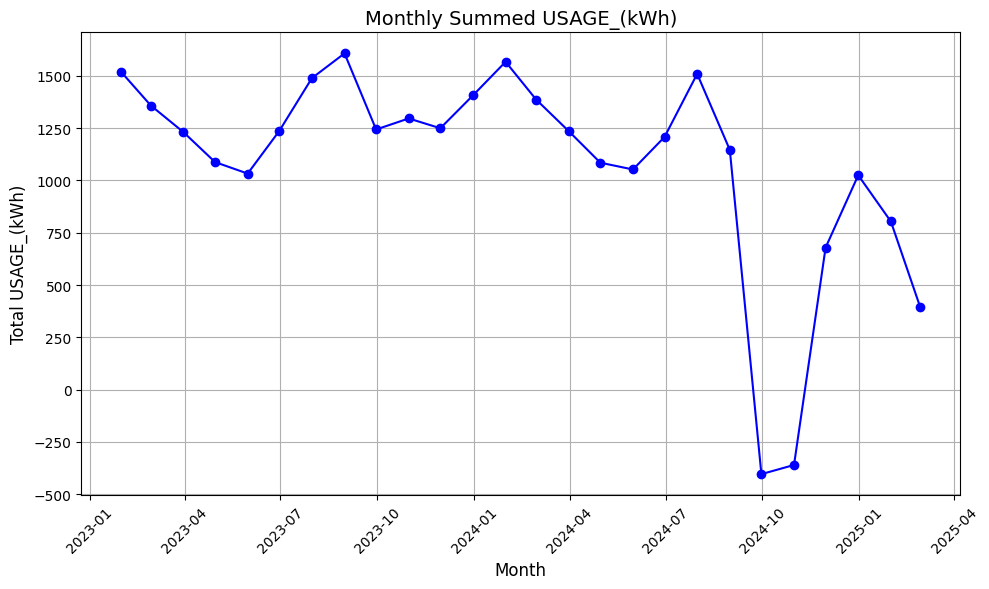

In [ ]:
#This chart shows odd negative data in October due to net metering, this future data is not utilized and is fixed in BI.
# Ensure 'DATE' is in datetime format
electric_agg['DATE'] = pd.to_datetime(electric_agg['DATE'])

# Step 1: Resample the data by month and sum the 'USAGE_(kWh)'
monthly_usage = electric_agg.resample('ME', on='DATE')['USAGE_(kWh)'].sum()

# Step 2: Plot the monthly summed usage
plt.figure(figsize=(10, 6))
plt.plot(monthly_usage.index, monthly_usage.values, marker='o', linestyle='-', color='b', label='USAGE_(kWh)')

# Adding titles and labels
plt.title('Monthly Summed USAGE_(kWh)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total USAGE_(kWh)', fontsize=12)

# Display the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Populate the future dates

In [81]:
# Ensure the 'DATE' column is in datetime format
electric_agg['DATE'] = pd.to_datetime(electric_agg['DATE'])

# Add 'month', 'day', and 'hour' columns to the dataframe for grouping
electric_agg['month'] = electric_agg['DATE'].dt.month
electric_agg['day'] = electric_agg['DATE'].dt.day
electric_agg['hour'] = electric_agg['DATE'].dt.hour

# Step 1: Generate future timestamps (starting from the last available timestamp in the data)
last_timestamp = electric_agg['DATE'].max()
future_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1),
                                  end='2034-12-31 23:00:00', freq='h')

# Step 2: Create a DataFrame for the future data
future_electric = pd.DataFrame({
    'date_timestamp': future_timestamps,
    'DATE': future_timestamps.date,
    'month': future_timestamps.month,
    'day': future_timestamps.day,
    'hour': future_timestamps.hour
})

# Step 3: Merge future data with the 'USAGE_(kWh)' and 'cost_per_kWh' columns
# Merging based on 'month', 'day', and 'hour' to project future data more accurately
future_electric = future_electric.merge(electric_agg[['month', 'day', 'hour', 'USAGE_(kWh)', 'cost_per_kWh']],
                                        on=['month', 'day', 'hour'], how='left')

# Step 4: Add the last_day_month column by converting 'DATE' column to datetime
future_electric['last_day_month'] = pd.to_datetime(future_electric['DATE']).apply(lambda x: x.replace(day=1) + pd.offsets.MonthEnd(1))

# Step 5: Mark the original data as 'actual' and the future data as 'estimated'
electric_agg['data_type'] = 'actual'
future_electric['data_type'] = 'estimated'

# Step 6: Concatenate the original data and the future data
final_electric_agg = pd.concat([electric_agg, future_electric], ignore_index=True)

# Display the final DataFrame
print(final_electric_agg.head())


                  DATE  hour last_day_month  USAGE_(kWh)  COST  \
0  2023-01-01 00:00:00     0     2023-01-31         1.46   0.0   
1  2023-01-01 00:00:00     0     2023-01-31         1.52   0.0   
2  2023-01-01 00:00:00     0     2023-01-31         1.14   0.0   
3  2023-01-01 00:00:00     0     2023-01-31         1.64   0.0   
4  2023-01-01 00:00:00     0     2023-01-31         2.74   0.0   

   ESTIMATED_USAGE      date_timestamp  cost_per_kWh  month  day data_type  
0              0.0 2023-01-01 00:00:00           0.0      1    1    actual  
1              0.0 2023-01-01 01:00:00           0.0      1    1    actual  
2              0.0 2023-01-01 02:00:00           0.0      1    1    actual  
3              0.0 2023-01-01 03:00:00           0.0      1    1    actual  
4              0.0 2023-01-01 04:00:00           0.0      1    1    actual  


In [82]:
# Define the filename
file_path = "iptv_future_electric_data.pkl"

# Save DataFrame locally
final_electric_agg.to_pickle(file_path)
print(f"✅ Future electric data saved to {file_path}")

# Push to GitHub
os.system(f"git add {file_path}")
os.system('git commit -m "Updated future electric data"')
os.system("git push origin main")
print("🚀 Future electric data pushed to GitHub!")


✅ Future electric data saved to iptv_future_electric_data.pkl
[main b32845e] Updated future electric data
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 iptv_future_electric_data.pkl
🚀 Future electric data pushed to GitHub!


To https://github.com/AmyHumke12/SolarProject
   e64c410..b32845e  main -> main


In [ ]:
# Define the GitHub raw file URL
url = "https://raw.githubusercontent.com/AmyHumke12/SolarProject/main/iptv_future_electric_data.pkl"

# Load the pickle file from GitHub
response = requests.get(url)
if response.status_code == 200:
    final_electric_agg = pickle.load(io.BytesIO(response.content))
    print("✅ Future electric data loaded successfully.")
    print(final_electric_agg.head())
else:
    raise Exception(f"❌ Failed to load data. HTTP Status: {response.status_code}")


                  DATE  hour last_day_month  USAGE_(kWh)  COST  \
0  2023-01-01 00:00:00     0     2023-01-31         1.46  0.22   
1  2023-01-01 00:00:00     0     2023-01-31         1.52  0.17   
2  2023-01-01 00:00:00     0     2023-01-31         1.14  0.24   
3  2023-01-01 00:00:00     0     2023-01-31         1.64  0.41   
4  2023-01-01 00:00:00     0     2023-01-31         2.74  0.14   

   ESTIMATED_USAGE      date_timestamp  cost_per_kWh  month  day data_type  
0              0.0 2023-01-01 00:00:00      0.150685      1    1    actual  
1              0.0 2023-01-01 01:00:00      0.111842      1    1    actual  
2              0.0 2023-01-01 02:00:00      0.210526      1    1    actual  
3              0.0 2023-01-01 03:00:00      0.250000      1    1    actual  
4              0.0 2023-01-01 04:00:00      0.051095      1    1    actual  


In [84]:
#DATE and ESTIMATED_USAGE are not needed
columns_to_drop = ['DATE','ESTIMATED_USAGE']

final_electric_agg = final_electric_agg.drop(columns=columns_to_drop, errors='ignore')
final_electric_agg.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284394 entries, 0 to 284393
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   hour            284394 non-null  int32         
 1   last_day_month  284394 non-null  datetime64[ns]
 2   USAGE_(kWh)     201389 non-null  float64       
 3   COST            18622 non-null   float64       
 4   date_timestamp  284394 non-null  datetime64[ns]
 5   cost_per_kWh    201336 non-null  float64       
 6   month           284394 non-null  int32         
 7   day             284394 non-null  int32         
 8   data_type       284394 non-null  object        
dtypes: datetime64[ns](2), float64(3), int32(3), object(1)
memory usage: 16.3+ MB


In [85]:
final_electric_agg

,hour,last_day_month,USAGE_(kWh),COST,date_timestamp,cost_per_kWh,month,day,data_type
0,0,2023-01-31,1.46,0.0,2023-01-01 00:00:00,0.0,1,1,actual
1,0,2023-01-31,1.52,0.0,2023-01-01 01:00:00,0.0,1,1,actual
2,0,2023-01-31,1.14,0.0,2023-01-01 02:00:00,0.0,1,1,actual
3,0,2023-01-31,1.64,0.0,2023-01-01 03:00:00,0.0,1,1,actual
4,0,2023-01-31,2.74,0.0,2023-01-01 04:00:00,0.0,1,1,actual
...,...,...,...,...,...,...,...,...,...
284389,19,2034-12-31,NaN,NaN,2034-12-31 19:00:00,NaN,12,31,estimated
284390,20,2034-12-31,NaN,NaN,2034-12-31 20:00:00,NaN,12,31,estimated
284391,21,2034-12-31,NaN,NaN,2034-12-31 21:00:00,NaN,12,31,estimated
284392,22,2034-12-31,NaN,NaN,2034-12-31 22:00:00,NaN,12,31,estimated


In [86]:
print(final_electric_agg['date_timestamp'].min(), final_electric_agg['date_timestamp'].max())


2023-01-01 00:00:00 2034-12-31 23:00:00


In [87]:
final_electric_agg.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284394 entries, 0 to 284393
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   hour            284394 non-null  int32         
 1   last_day_month  284394 non-null  datetime64[ns]
 2   USAGE_(kWh)     201389 non-null  float64       
 3   COST            18622 non-null   float64       
 4   date_timestamp  284394 non-null  datetime64[ns]
 5   cost_per_kWh    201336 non-null  float64       
 6   month           284394 non-null  int32         
 7   day             284394 non-null  int32         
 8   data_type       284394 non-null  object        
dtypes: datetime64[ns](2), float64(3), int32(3), object(1)
memory usage: 16.3+ MB


In [88]:
# Define the filename
file_path = "iptv_future_electric_data.pkl"

# Save DataFrame locally
final_electric_agg.to_pickle(file_path)
print(f"✅ Future electric data saved to {file_path}")

# Push to GitHub
os.system(f"git add {file_path}")
os.system('git commit -m "Updated future electric data"')
os.system("git push origin main")
print("🚀 Future electric data pushed to GitHub!")


✅ Future electric data saved to iptv_future_electric_data.pkl
[main 02785d0] Updated future electric data
 1 file changed, 0 insertions(+), 0 deletions(-)
🚀 Future electric data pushed to GitHub!


To https://github.com/AmyHumke12/SolarProject
   b32845e..02785d0  main -> main
